<a href="https://colab.research.google.com/github/Leo-Mak/Practicum/blob/main/diagnostics_of_marketing_returns/diagnostics_of_marketing_returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Диагностика окупаемости рекламы (маркетинговая аналитика)

## **Цель исследования**
</br>Найти причины убытков, полученных в течение нескольких последних месяцев несмотря на огромные вложения в рекламу, и предложить меры по выходу на окупаемость. </br>В бизнес-плане развлекательного приложения заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

## **План работ**
**1. Предобработка данных**  
**2. Создание функций для расчёта и визуализации метрик**  
**3. Анализ структуры пользователей**  
**4. Анализ эффективности маркетинга**  
**5. Расчет окупаемости и декомпозиция проблемы**  
**6. Выводы**

## **Описание данных**
</br> Момент анализа - 1 ноября 2019 года.
</br> Данные о пользователях с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях (visits_info_short.csv),
- выгрузка их покупок за этот период (orders_info_short.csv),
- рекламные расходы (costs_info_short.csv).

**Структура visits_info_short.csv**

| Column           | Desciption       |
| ---------------- | ----------------- |
| User Id | уникальный идентификатор пользователя
| Region | страна пользователя
| Device | тип устройства пользователя
| Channel | идентификатор источника перехода
| Session Start | дата и время начала сессии
| Session End | дата и время окончания сессии

**Структура orders_info_short.csv**

| Column           | Desciption       |
| ---------------- | ----------------- |
| User Id | уникальный идентификатор пользователя
| Event Dt | дата и время покупки
| Revenue | сумма заказа

**Структура costs_info_short.csv**

| Column           | Desciption       |
| ---------------- | ----------------- |
| dt | дата проведения рекламной кампании
| Channel | идентификатор рекламного источника
| costs | расходы на эту кампанию

# Предобработка данных

## Получим общую информацию о файле с данными

In [ ]:
# импортируем бибилиотеки и задаем общие настройки
import pandas as pd
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

In [ ]:
# mount google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# открываем файл с данными
path1 = '/content/drive/MyDrive/Colab files/practicum_project_6/visits_info_short.csv'
path2 = '/content/drive/MyDrive/Colab files/practicum_project_6/orders_info_short.csv'
path3 = '/content/drive/MyDrive/Colab files/practicum_project_6/costs_info_short.csv'
visits = pd.read_csv(path1)
orders = pd.read_csv(path2)
costs = pd.read_csv(path3)

In [ ]:
#получим общую информацию
count = 0
for i in (visits, orders, costs):
  count +=1
  display(f'Таблица {count}: размер, количество ненулевых значений в столбцах и формат данных')
  display(i.info())
  display(f'Таблица {count}: просмотр первых 10 строк', i.head(10))
  display('*'*50)

'Таблица 1: размер, количество ненулевых значений в столбцах и формат данных'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

'Таблица 1: просмотр первых 10 строк'

User Id         Region   Device         Channel        Session Start  \
0  981449118918  United States   iPhone         organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone         organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac         organic  2019-05-01 14:09:25   
3  326433527971  United States  Android          TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac         organic  2019-05-01 03:33:35   
5   90242400005  United States   iPhone  RocketSuperAds  2019-05-01 07:14:52   
6   43958116050  United States  Android         organic  2019-05-01 09:03:21   
7  185365244969  United States   iPhone         organic  2019-05-01 09:37:03   
8  446013509831  United States   iPhone  RocketSuperAds  2019-05-01 10:26:00   
9  100970711362  United States      Mac          TipTop  2019-05-01 04:39:53   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  
5  2019-05-01 08:19:56  
6  2019-05-01 10:08:39  
7  2019-05-01 10:00:43  
8  2019-05-01 10:59:17  
9  2019-05-01 04:57:05

'**************************************************'

'Таблица 2: размер, количество ненулевых значений в столбцах и формат данных'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

'Таблица 2: просмотр первых 10 строк'

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99
5  129100331057  2019-05-01 01:56:28     4.99
6  626807144131  2019-05-01 02:39:21     4.99
7  914062168985  2019-05-01 02:02:18     4.99
8  769669137453  2019-05-01 03:39:47     4.99
9  434198630691  2019-05-01 18:16:50     5.99

'**************************************************'

'Таблица 3: размер, количество ненулевых значений в столбцах и формат данных'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

'Таблица 3: просмотр первых 10 строк'

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1
5  2019-05-06  FaceBoom  118.8
6  2019-05-07  FaceBoom  101.2
7  2019-05-08  FaceBoom  100.1
8  2019-05-09  FaceBoom   93.5
9  2019-05-10  FaceBoom  104.5

'**************************************************'

In [ ]:
# для параметра costs['cost'] проверим диапазон значений
display(costs.describe())

costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000

In [ ]:
# для параметра costs['cost'] проверим количество значений для каждого канала продаж costs['channel']
display('Количество значений параметра cost для каждого канала рекламы', costs["Channel"].value_counts())

'Количество значений параметра cost для каждого канала рекламы'

FaceBoom              180
MediaTornado          180
RocketSuperAds        180
TipTop                180
YRabbit               180
AdNonSense            180
LeapBob               180
OppleCreativeMedia    180
WahooNetBanner        180
lambdaMediaAds        180
Name: Channel, dtype: int64

##Заменим названия столбцов

In [ ]:
count = 0
for i in (visits, orders, costs):
  count += 1
  i.columns = i.columns.str.lower().str.replace(' ', '_')
  display(f'Столбцы таблицы {count}: ', i.columns)
  display('*'*50)

'Столбцы таблицы 1: '

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

'**************************************************'

'Столбцы таблицы 2: '

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

'**************************************************'

'Столбцы таблицы 3: '

Index(['dt', 'channel', 'costs'], dtype='object')

'**************************************************'

## Преобразуем данные в нужные типы

In [ ]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
#costs['dt'] = costs['dt'].astype('datetime64')
costs['dt'] = pd.to_datetime(costs['dt']).dt.date # поскольку в dt у нас нет данных о времени, сразу приводим его к date

count = 0
for j in (visits, orders, costs):
  count +=1
  display(f'Формат данных {count}:', j.dtypes)

'Формат данных 1:'

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

'Формат данных 2:'

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

'Формат данных 3:'

dt          object
channel     object
costs      float64
dtype: object

In [ ]:
# выведем временной диапазон данных
count = 0
for i in (visits['session_start'], orders['event_dt'], costs['dt']):
  count += 1
  display(f'Параметр {count} мин: {min(i)}, макс: {max(i)}')

'Параметр 1 мин: 2019-05-01 00:00:41, макс: 2019-10-31 23:59:23'

'Параметр 2 мин: 2019-05-01 00:28:11, макс: 2019-10-31 23:56:56'

'Параметр 3 мин: 2019-05-01, макс: 2019-10-27'

## Устраним дубликаты

In [ ]:
# проверим на полные дубликаты
count = 0
for i in (visits, orders, costs):
  count += 1
  display(f'В таблице {count} количество полных дубликатов: {i.duplicated().sum()}')

'В таблице 1 количество полных дубликатов: 0'

'В таблице 2 количество полных дубликатов: 0'

'В таблице 3 количество полных дубликатов: 0'

In [ ]:
count = 0
for j in (visits, orders, costs):
  count +=1
  display(f'Формат данных {count}:', j.dtypes)

'Формат данных 1:'

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

'Формат данных 2:'

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

'Формат данных 3:'

dt          object
channel     object
costs      float64
dtype: object

In [ ]:
# проверим таблицу costs на дубликаты по паре параметров dt, channel
display(f'Количество дубликатов: {costs.duplicated(subset=("dt", "channel")).sum()}')

'Количество дубликатов: 0'

Результат
- перевели названия столбцов в snake_case
- исправили типы данных c `object` на `datetime64` в параметрах `visits['session_start']`, `visits['session_end']`, `orders['event_dt']`, `costs['dt']`
- обнаружили, что временной диапазон данных visits['session_start'], orders['event_dt'] выходит за предельную дату 27.10, следовательно при формировании профилей необходимо проверить, что они не выходят за эту дату
- пропуски и дубликаты не обнаружены

# Создание функций для расчета и визуализации метрик

## Добавили график структуры когорты
- при анализе ROI, LTV и CAC в разбивке по dimensions важно понимать вклад каждого компонента, выраженного в доле когорты, соответствующей значению параметра dimensions, от общего размера когорты новых пользователей
- данная структура когорты параметру dimensions одинаково применима к показателям ROI, LTV и CAC
- график добавили к Функции для визуализации LTV и ROI
- новый график отображается только при заполненном параметре dimesions
- применяется сглаживание, соответствущие параметру window

## Добавили функцию для вывода структуры пользователей в таблице
- для раздела Анализ структуры пользователей

## Библиотека используемых функций
Это функции для вычисления значений метрик:  
get_profiles() — для создания профилей пользователей,  
get_retention() — для подсчёта Retention Rate,  
get_conversion() — для подсчёта конверсии,  
get_ltv() — для подсчёта LTV.  
А также функции для построения графиков:  
filter_data() — для сглаживания данных,  
plot_retention() — для построения графика Retention Rate,  
plot_conversion() — для построения графика конверсии,  
plot_ltv_roi() — для визуализации LTV и ROI.

### Функция для создания профилей пользователей

In [ ]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчёта удержания

In [ ]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета конверсии

In [ ]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета LTV и ROI

In [ ]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC,
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания фрейма

In [ ]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

### Функция для визуализации удержания

In [ ]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [ ]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [ ]:
## функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history_for_chart6 = roi_history
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей (CAC)')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    # шестой график - структура когорты
    # тип графика - нормированная диаграмма с областями и накоплением
    levels = roi_history_for_chart6.index.nlevels
    dim = roi_history_for_chart6.index.names[:len(roi_history.index.names)-1]
    if levels > 1:
      roi_dim_shares = roi_history_for_chart6.reset_index().pivot_table(index='dt', columns=dim, values='cohort_size', aggfunc='sum')
      roi_dim_shares['total'] = roi_dim_shares.sum(axis=1)
      roi_dim_shares = roi_dim_shares.div(roi_dim_shares['total'], axis=0).drop(columns='total')
      ax6 = plt.subplot(2, 3, 6, sharex=ax3)
      ax6.stackplot(roi_dim_shares.index.values, filter_data(roi_dim_shares, window).T*100)
      plt.grid(visible=True)
      plt.title('Структура когорты')
      plt.xlabel('Дата привлечения')
      plt.ylabel('Доля (%)')
      ax6.margins(0, 0) # Set margins to avoid "whitespace"
      plt.legend(roi_dim_shares.columns)

    plt.tight_layout()
    plt.show()

### Функция для вывода структуры пользователей в таблице

In [ ]:
def structure(profiles, dimension):
  str = profiles.pivot_table(index=dimension, aggfunc=({'user_id':'count', 'payer':['mean', 'sum']}))
  str.columns = ('%_paying_of_dimension', '%_paying_of_total', '#_users')
  str = str.loc[:,['#_users', '%_paying_of_total', '%_paying_of_dimension']]
  str['%_paying_of_dimension'] = round(str['%_paying_of_dimension'] * 100, 0)
  str['%_paying_of_total'] = round(str['%_paying_of_total'] / str['%_paying_of_total'].sum() * 100, 0)
  display(str.sort_values(by='%_paying_of_total', ascending=False))

# Анализ структуры пользователей
Проверим наличие аномалий

## Статистика профилей пользователей

In [ ]:
events = None  # других событий нет
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [ ]:
# получаем профили с CAC
users = get_profiles(visits, orders, events, costs)
display(users.info())
display(users.sort_values(by='first_ts', ascending=True).tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


None

user_id            first_ts             channel   device  \
89975   598664469855 2019-10-27 23:55:23          AdNonSense   iPhone   
2740     18615786610 2019-10-27 23:55:42             organic  Android   
64788   430005587232 2019-10-27 23:56:13  OppleCreativeMedia       PC   
52833   350809890323 2019-10-27 23:58:24              TipTop   iPhone   
111023  739432831998 2019-10-27 23:59:04              TipTop   iPhone   

               region          dt               month  payer  acquisition_cost  
89975              UK  2019-10-27 2019-10-27 23:55:23  False          1.020000  
2740          Germany  2019-10-27 2019-10-27 23:55:42  False          0.000000  
64788         Germany  2019-10-27 2019-10-27 23:56:13  False          0.257246  
52833   United States  2019-10-27 2019-10-27 23:58:24  False          3.458824  
111023  United States  2019-10-27 2019-10-27 23:59:04  False          3.458824

In [ ]:
display('Дата привлечения первого пользователя:', users['dt'].min())
display('Дата привлечения последнего пользователя:', users['dt'].max())
display('Всего привлечено пользователей:', users['dt'].count())
display('Первые 5 пользователей:', users.sort_values(by='first_ts', ascending=False).head())

'Дата привлечения первого пользователя:'

datetime.date(2019, 5, 1)

'Дата привлечения последнего пользователя:'

datetime.date(2019, 10, 27)

'Всего привлечено пользователей:'

150008

'Первые 5 пользователей:'

user_id            first_ts             channel   device  \
111023  739432831998 2019-10-27 23:59:04              TipTop   iPhone   
52833   350809890323 2019-10-27 23:58:24              TipTop   iPhone   
64788   430005587232 2019-10-27 23:56:13  OppleCreativeMedia       PC   
2740     18615786610 2019-10-27 23:55:42             organic  Android   
89975   598664469855 2019-10-27 23:55:23          AdNonSense   iPhone   

               region          dt               month  payer  acquisition_cost  
111023  United States  2019-10-27 2019-10-27 23:59:04  False          3.458824  
52833   United States  2019-10-27 2019-10-27 23:58:24  False          3.458824  
64788         Germany  2019-10-27 2019-10-27 23:56:13  False          0.257246  
2740          Germany  2019-10-27 2019-10-27 23:55:42  False          0.000000  
89975              UK  2019-10-27 2019-10-27 23:55:23  False          1.020000

## Структура по странам, устройствам, каналам рекламы

In [ ]:
for i in ('region', 'device', 'channel'):
  structure(users, i)

#_users  %_paying_of_total  %_paying_of_dimension
region                                                          
United States   100002               78.0                    7.0
UK               17575                8.0                    4.0
France           17450                7.0                    4.0
Germany          14981                7.0                    4.0

#_users  %_paying_of_total  %_paying_of_dimension
device                                                    
iPhone     54479               38.0                    6.0
Android    35032               23.0                    6.0
Mac        30042               22.0                    6.0
PC         30455               17.0                    5.0

#_users  %_paying_of_total  %_paying_of_dimension
channel                                                              
FaceBoom              29144               40.0                   12.0
TipTop                19561               21.0                   10.0
organic               56439               13.0                    2.0
AdNonSense             3880                5.0                   11.0
WahooNetBanner         8553                5.0                    5.0
RocketSuperAds         4448                4.0                    8.0
LeapBob                8553                3.0                    3.0
OppleCreativeMedia     8605                3.0                    3.0
lambdaMediaAds         2149                3.0                   10.0
MediaTornado           4364                2.0                    4.0
YRabbit                4312                2.0                    4.0

Выводы:
- пользовательские профили сформированы за период, соответствующий периоду в условиях задания: с 01.05.2019 по 27.10.2019
- всего за этот период привлечено 150008 новых пользователей
- наибольшее количество платящих пользователей пришло из страны United States, у остальных стран близкие доли платящих пользователей
- наибольшее количество платящих пользователей пришло через устройства iPhone, на втором месте Android и Mac c близкими значениями
- среди рекламных каналов наибольшее количество платящих пользователей принесли FaceBoom и TipTop
- в целом, такая классификация малоинформативна, т.к. не учитывает важные особенности: распредение устройств и каналов рекламы по регионам, используемый для оценки окупаемости лайфтайм и т.д.

# Анализ эффективности маркетинга

## Структура расходов на маркетинг

In [ ]:
# выведем общие расходы на маркетинг
costs_total = costs.pivot_table(index='channel', values='costs', aggfunc='sum', margins=True).sort_values(by='costs', ascending=False)
display(costs_total)
costs_sorted = costs_total.sort_values(by='costs').index.values[0:10]
costs_sorted_dropped = costs_total.sort_values(by='costs').index.values[0:8]
#display(costs_sorted)

costs
channel                      
All                 105497.30
TipTop               54751.30
FaceBoom             32445.60
WahooNetBanner        5151.00
AdNonSense            3911.25
OppleCreativeMedia    2151.25
RocketSuperAds        1833.00
LeapBob               1797.60
lambdaMediaAds        1557.60
MediaTornado           954.48
YRabbit                944.22

In [ ]:
# добавим недели и месяцы в таблицу costs
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
display(costs.head())

dt   channel  costs  month  week
0  2019-05-01  FaceBoom  113.3      5    18
1  2019-05-02  FaceBoom   78.1      5    18
2  2019-05-03  FaceBoom   85.8      5    18
3  2019-05-04  FaceBoom  136.4      5    18
4  2019-05-05  FaceBoom  122.1      5    18

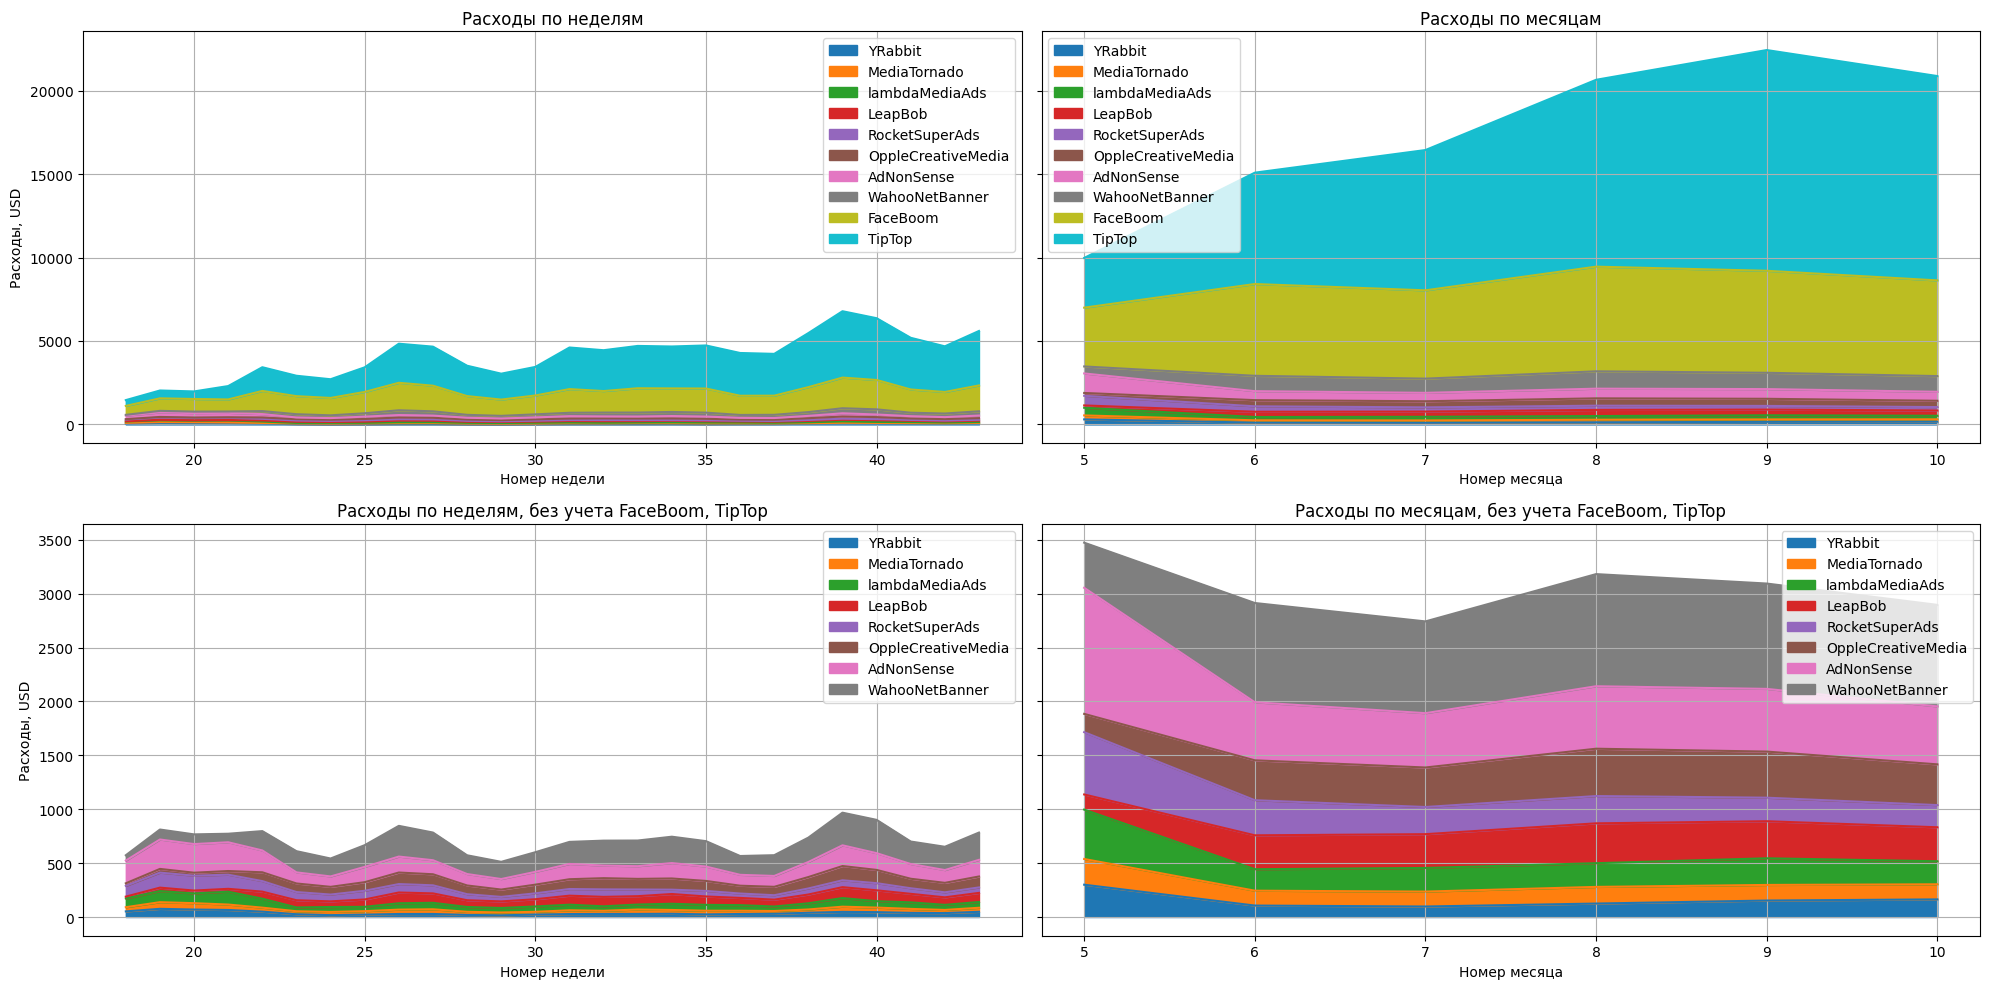

In [ ]:
# визуализируем динамику расходов в разбивке по каналам рекламы
# задаём сетку отрисовки графиков
plt.figure(figsize=(20, 10))

# первый график — разбивка по неделям
ax1 = plt.subplot(2, 2, 1)
costs_week = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
costs_week = costs_week.loc[:,costs_sorted]
costs_week.plot.area(x=None, y=None, stacked=True, ax=ax1)
plt.grid(visible=True)
plt.legend()
plt.xlabel('Номер недели')
plt.ylabel('Расходы, USD')
plt.title('Расходы по неделям')

# второй график — разбивка по месяцам
ax2 = plt.subplot(2, 2, 2, sharey=ax1)
costs_month = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
costs_month = costs_month.loc[:,costs_sorted]
costs_month.plot.area(x=None, y=None, stacked=True, ax=ax2)
plt.grid(visible=True)
plt.legend()
plt.xlabel('Номер месяца')
plt.title('Расходы по месяцам')

# третий график — разбивка по неделям без FaceBoom, TipTop
ax3 = plt.subplot(2, 2, 3)
costs_week = costs_week.drop(columns=['FaceBoom', 'TipTop'])
costs_week = costs_week.loc[:,costs_sorted_dropped]
costs_week.plot.area(x=None, y=None, stacked=True, ax=ax3)
plt.grid(visible=True)
plt.legend()
plt.xlabel('Номер недели')
plt.ylabel('Расходы, USD')
plt.title('Расходы по неделям, без учета FaceBoom, TipTop')

# четвертый график — разбивка по месяцам без FaceBoom, TikTop
ax4 = plt.subplot(2, 2, 4, sharey=ax3)
costs_month = costs_month.drop(columns=['FaceBoom', 'TipTop'])
costs_month = costs_month.loc[:,costs_sorted_dropped]
costs_month.plot.area(x=None, y=None, stacked=True, ax=ax4)
plt.grid(visible=True)
plt.legend()
plt.xlabel('Номер месяца')
plt.title('Расходы по месяцам, без учета FaceBoom, TipTop')


plt.tight_layout()
plt.show()

## Сравнение стоимости привлечения пользователя (CAC)

In [ ]:
#рассчитаем количество пользователей, привлеченных из каждого источника
costs_total['new_users'] = users.pivot_table(index='channel', values='user_id', aggfunc='count', margins=True)
costs_total['cac'] = costs_total['costs'] / costs_total['new_users']
costs_total = costs_total.iloc[1:costs_total['new_users'].count()].sort_values(by='cac').append(costs_total.iloc[[0]])
display(costs_total)

costs  new_users       cac
channel                                           
LeapBob               1797.60       8553  0.210172
MediaTornado           954.48       4364  0.218717
YRabbit                944.22       4312  0.218975
OppleCreativeMedia    2151.25       8605  0.250000
RocketSuperAds        1833.00       4448  0.412095
WahooNetBanner        5151.00       8553  0.602245
lambdaMediaAds        1557.60       2149  0.724802
AdNonSense            3911.25       3880  1.008054
FaceBoom             32445.60      29144  1.113286
TipTop               54751.30      19561  2.799003
All                 105497.30     150008  0.703278

Наблюдения:
- по валовым расходам каналы рекламы TipTop и FaceBoom на порядок превосходят остальные каналы
- причем динамика расходов такова, что в течение рассматриваемого периода наибольшее увеличение расходов пришлось на два указанных канала продаж, за счет этого выросли и общие расходы на рекламу
- среди остальных каналов рекламы, расходы в мае уменьшились более чем вдвое на AdNonSense и увеличились на WahooNetBanner
- соотношение расходов на привлечение пользователя (CAC) из различных каналов рекламы показывает, что дешевле всего привлечение пользователя обходится через LeapBob, MediaTornado, YRabbit и OppleCreativeMedia, в то время как самый дорогой канал - TipTop

# Расчет окупаемости и декомпозиция проблемы

## Анализируем окупаемость рекламы c помощью обобщенных графиков ROI, LTV и CAC

### Канал привлечения organic отделим от остальных  
- стоимость привлечения пользователей (CAC) для него равна нулю, и соответствующие пользователи не должны учитываться при расчете окупаемости рекламы и ее компонентов
- метрики аудитории этого канала могут быть полезны для понимания эффективности рекламных каналов

In [ ]:
# добавляем параметр organic, принимающий значение True, когда параметр channel='organic', и False в остальных случаях
users1 = users
users1['organic'] = users1['channel'] == 'organic'
display(users1.head())

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt               month  payer  acquisition_cost  organic  
0  2019-05-07 2019-05-07 20:58:57   True          1.088172    False  
1  2019-07-09 2019-07-09 12:46:07  False          1.107237    False  
2  2019-10-01 2019-10-01 09:58:33  False          0.000000     True  
3  2019-08-22 2019-08-22 21:35:48  False          0.988235    False  
4  2019-10-02 2019-10-02 00:07:44  False          0.230769    False

In [ ]:
# считаем LTV и ROI с разбивкой по dimensions
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users1, orders, observation_date, horizon_days, dimensions=['organic']
)

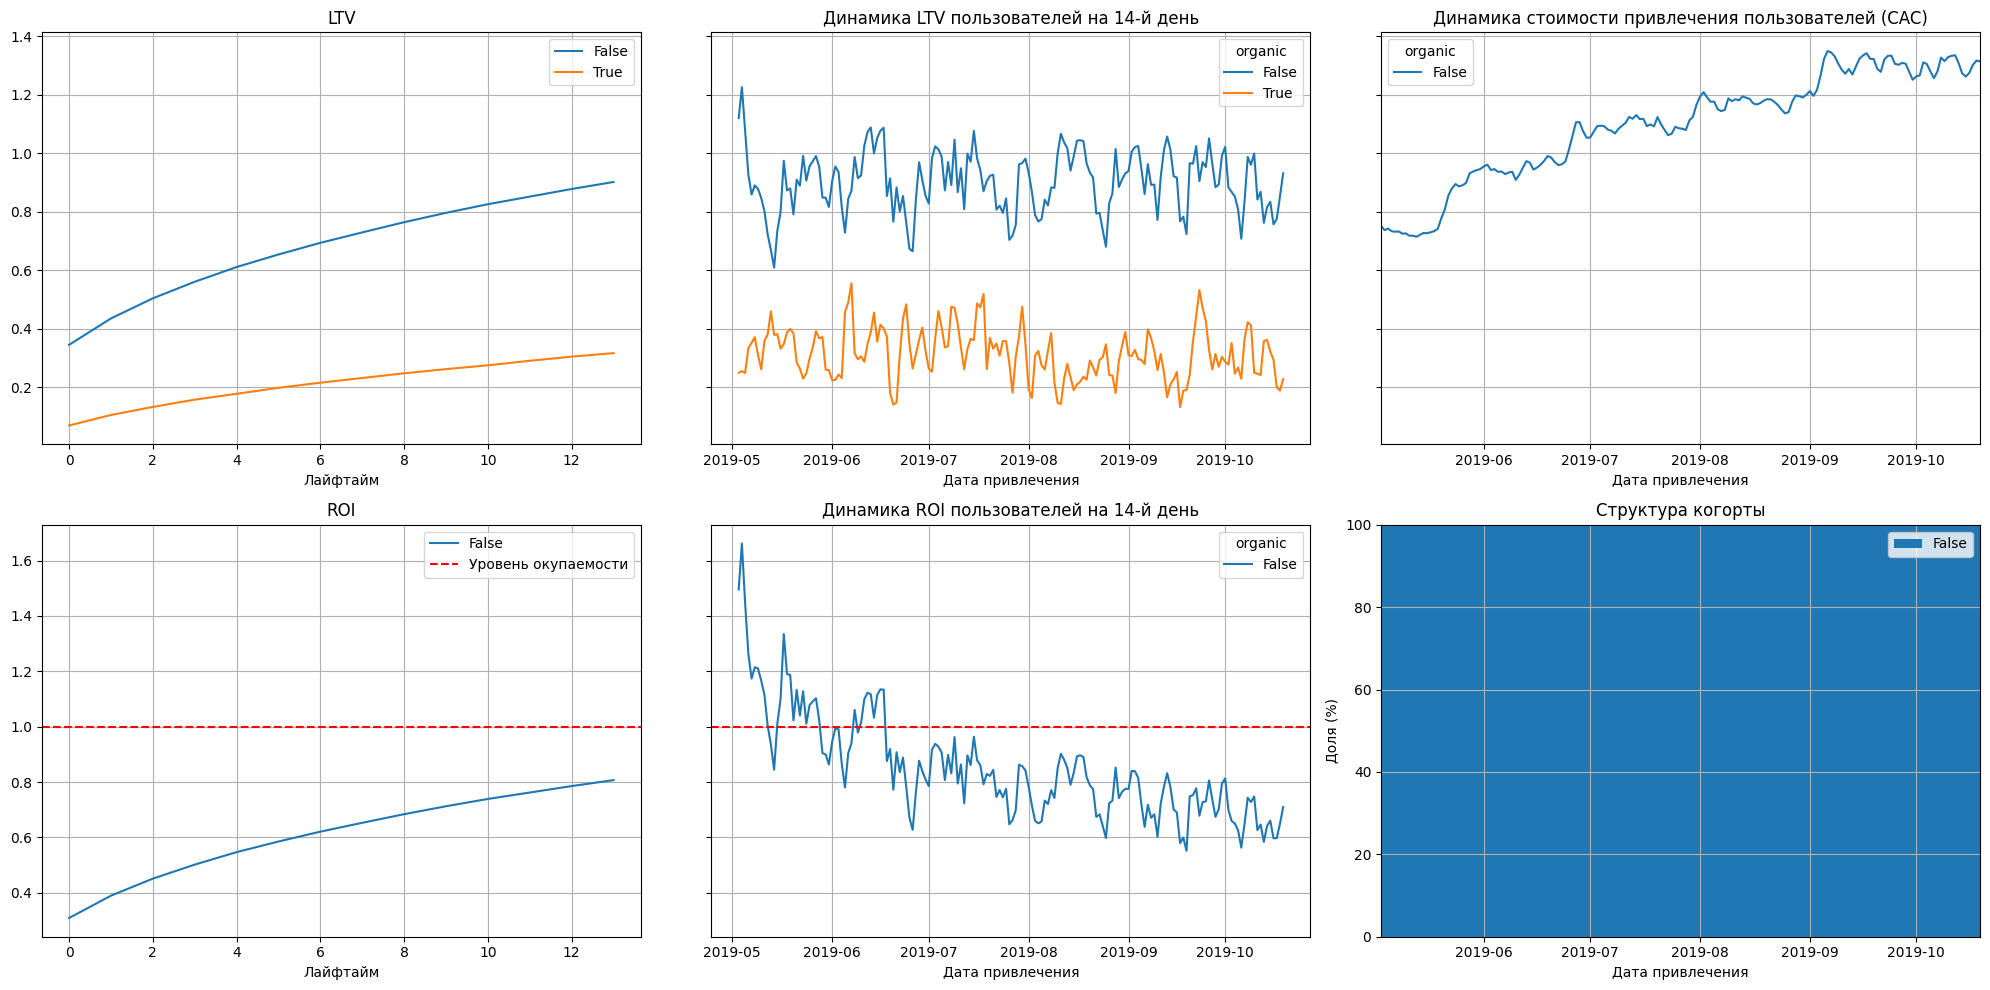

In [ ]:
# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=3)

Наблюдения на основе обобщенных графиков ROI, LTV и CAC:  
1) средняя окупаемость рекламы (ROI) за рассматриваемый период около 80%  
2) окупаемость рекламы на 14 день (ROI) снижалась в течение всего рассматриваемого периода, по результатам июня опустилась в зону убыточности; по динамике можно выделить 2 периода:
- крутое падение в первой половине мая, обусловленное динамикой доходов от пользователя (LTV)
- более пологая нисходящая тенденция начиная со второй половины мая, повторяющая график роста расходов на привлечение новых пользователей (CAC)
[//]:#
3) рост расходов на привлечение одного "неорганического" нового пользователя (CAC) является **одним фактором потери окупаемости рекламы (ROI)**, который надо объяснить  
4) отсутствие положительной динамики доходов от "неорганического" пользователя (LTV) в течение всего наблюдаемого периода и падение в начале мая является **вторым фактором потери окупаемости рекламы (ROI)**  
5) Отдельно отметили, что привлеченные рекламой пользователи в среднем приносят устойчиво больший доход (LTV), чем органический траффик.

## Рассмотрим окупаемость рекламы (ROI) в различных разбивках
- по региону
- по каналу рекламы
- по устройству
- по платящим пользователям

In [ ]:
# сделаем срез "неорганических" пользователей для дальнейшего анализа
users_nonorg = users1.query('organic==False')

### Разбивка по региону

In [ ]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_nonorg, orders, observation_date, horizon_days, dimensions=['region']
)

In [ ]:
# выведем структуру ROI по количеству новых пользователей за последние 30 дней
dim = roi_history.index.names[:len(roi_history.index.names)-1]
roi_dim_shares = roi_history.reset_index().pivot_table(index='dt', columns=dim, values='cohort_size', aggfunc='sum')
roi_dim_shares['total'] = roi_dim_shares.sum(axis=1)
roi_dim_shares = roi_dim_shares.div(roi_dim_shares['total'], axis=0).drop(columns='total')
#display(roi_dim_shares)
roi_dim_shares_30d = roi_dim_shares.iloc[roi_dim_shares.shape[0]-30 :]
display(roi_dim_shares_30d.mean(axis=0).sort_values(ascending=False))

region
United States    0.661711
UK               0.117877
France           0.115400
Germany          0.105012
dtype: float64

In [ ]:
# ROI за последние 30 дней
dim = roi_history.index.names[:len(roi_history.index.names)-1]
roi_dim_shares = roi_history.reset_index().pivot_table(index='dt', columns=dim, values=13, aggfunc='sum')
#display(roi_dim_shares)
roi_dim_shares_30d = roi_dim_shares.iloc[roi_dim_shares.shape[0]-30 :]
display(roi_dim_shares_30d.mean(axis=0).sort_values(ascending=False))

region
Germany          1.934583
France           1.535253
UK               1.530233
United States    0.568201
dtype: float64

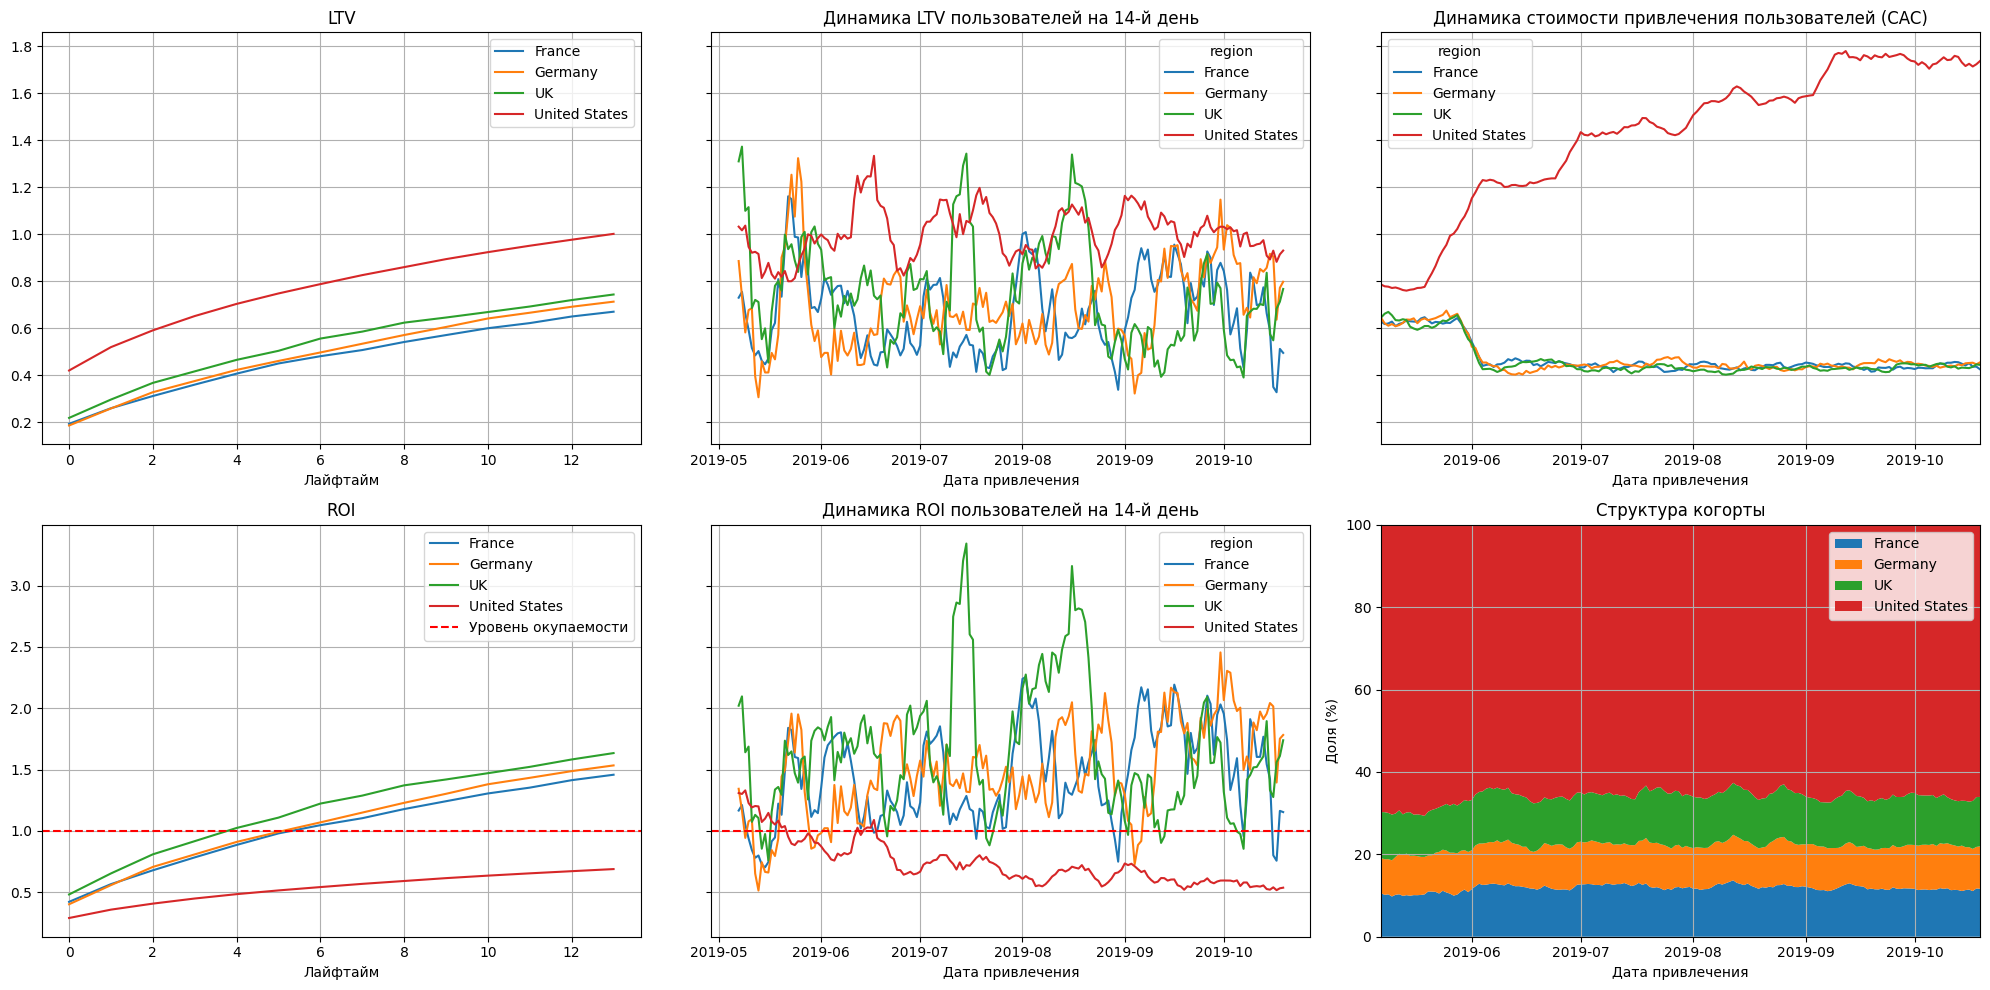

In [ ]:
# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

Наблюдения:
- динамика ROI пользователей United States была определяющим негативным фактором для общего ROI с учетом **более 60% доли пользователей United States среди всех "неорганических" пользователей**, далее сфокусируемся на этом компоненте
- по ROI пользователи из United States - единственные, кто после июня стабильно находились ниже 100%. Средние значения ROI пользователей остальных стран на уровне 150-160% для лайфтайма 14 дней и колебания происходят вокруг этого уровня. ROI United States продолжает медленное асимптотическое приближение к 50%.
- пользователи из United States приносили значительно более высокий доход, причем различие объясняется большей суммой покупки в первый день лайфтайма (USD 0,4 против примерно USD 0,2), а далее динамика не отличалась от пользователей из других стран - эта особенность **привлекает внимание**
- доход от пользователей по всем странам колебался вокруг своих средних значений; выраженных тенденций не было; в первой половине мая LTV упали синхронно, в последующем восстановились и такой синхронности не наблюдалось. Возможно влияние на весь рекламный рынок единовременного фактора, при этом влияние сезонности маловероятно, т.к. у органических пользователей аналогичного движения нет.
- расходы на привлечение пользователя в конце мая резко понизились во всех странах, кроме United States, где они наоборот подскочили - эта дивергенция **привлекает внимание**
- также **привлекают внимание** разнонаправленные тенденции CAC начиная с июня, которые оказали наибольшее воздействие на ROI для United States: расходы по этой стране продолжали поступательно расти, в то время как для остальных стран они стабилизировались на одном общем уровне
[//]:#
Теперь мы знаем убыточную страну, из-за которой снизился общий ROI.


### Разбивка пользователей United States по каналу рекламы

In [ ]:
# делаем срез пользателей United States
users_us = users_nonorg.query('region == "United States"')

In [ ]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_us, orders, observation_date, horizon_days, dimensions=['channel']
)

In [ ]:
# выведем таблицу ROI
display(roi)

cohort_size       cac       0.0       1.0       2.0       3.0  \
channel                                                                         
FaceBoom              27544  1.113419  0.526040  0.593510  0.629343  0.654599   
MediaTornado           4167  0.219035  0.627684  0.874814  1.127410  1.340729   
RocketSuperAds         4251  0.417431  0.497256  0.763336  0.948932  1.092347   
TipTop                18498  2.757774  0.124575  0.180359  0.226321  0.268272   
YRabbit                4102  0.217087  0.752238  0.983122  1.179250  1.400049   

                     4.0       5.0       6.0       7.0       8.0       9.0  \
channel                                                                      
FaceBoom        0.671035  0.682914  0.695801  0.704818  0.711685  0.719204   
MediaTornado    1.516873  1.675432  1.773841  1.910531  2.008962  2.107371   
RocketSuperAds  1.235204  1.367935  1.531090  1.646391  1.767923  1.892809   
TipTop          0.305449  0.339298  0.367570  0.397585  0.424763  0.451627   
YRabbit         1.641119  1.786814  1.910094  2.022179  2.123045  2.212703   

                    10.0      11.0      12.0      13.0  
channel                                                 
FaceBoom        0.724119  0.729488  0.734210  0.737790  
MediaTornado    2.216726  2.320602  2.402610  2.436519  
RocketSuperAds  1.991795  2.070538  2.152657  2.237019  
TipTop          0.475535  0.497310  0.517679  0.539532  
YRabbit         2.313569  2.414457  2.516446  2.578086

In [ ]:
# выведем структуру ROI по количеству новых пользователей за последние 30 дней
dim = roi_history.index.names[:len(roi_history.index.names)-1]
roi_dim_shares = roi_history.reset_index().pivot_table(index='dt', columns=dim, values='cohort_size', aggfunc='sum')
roi_dim_shares['total'] = roi_dim_shares.sum(axis=1)
roi_dim_shares = roi_dim_shares.div(roi_dim_shares['total'], axis=0).drop(columns='total')
#display(roi_dim_shares)
roi_dim_shares_30d = roi_dim_shares.iloc[roi_dim_shares.shape[0]-30 :]
display(roi_dim_shares_30d.mean(axis=0).sort_values(ascending=False))

channel
FaceBoom          0.481554
TipTop            0.325749
RocketSuperAds    0.065324
YRabbit           0.064858
MediaTornado      0.062515
dtype: float64

In [ ]:
# ROI за последние 30 дней
dim = roi_history.index.names[:len(roi_history.index.names)-1]
roi_dim_shares = roi_history.reset_index().pivot_table(index='dt', columns=dim, values=13, aggfunc='sum')
#display(roi_dim_shares)
roi_dim_shares_30d = roi_dim_shares.iloc[roi_dim_shares.shape[0]-30 :]
display(roi_dim_shares_30d.mean(axis=0).sort_values(ascending=False))

channel
MediaTornado      2.832031
RocketSuperAds    2.756559
YRabbit           2.568873
FaceBoom          0.752499
TipTop            0.398067
dtype: float64

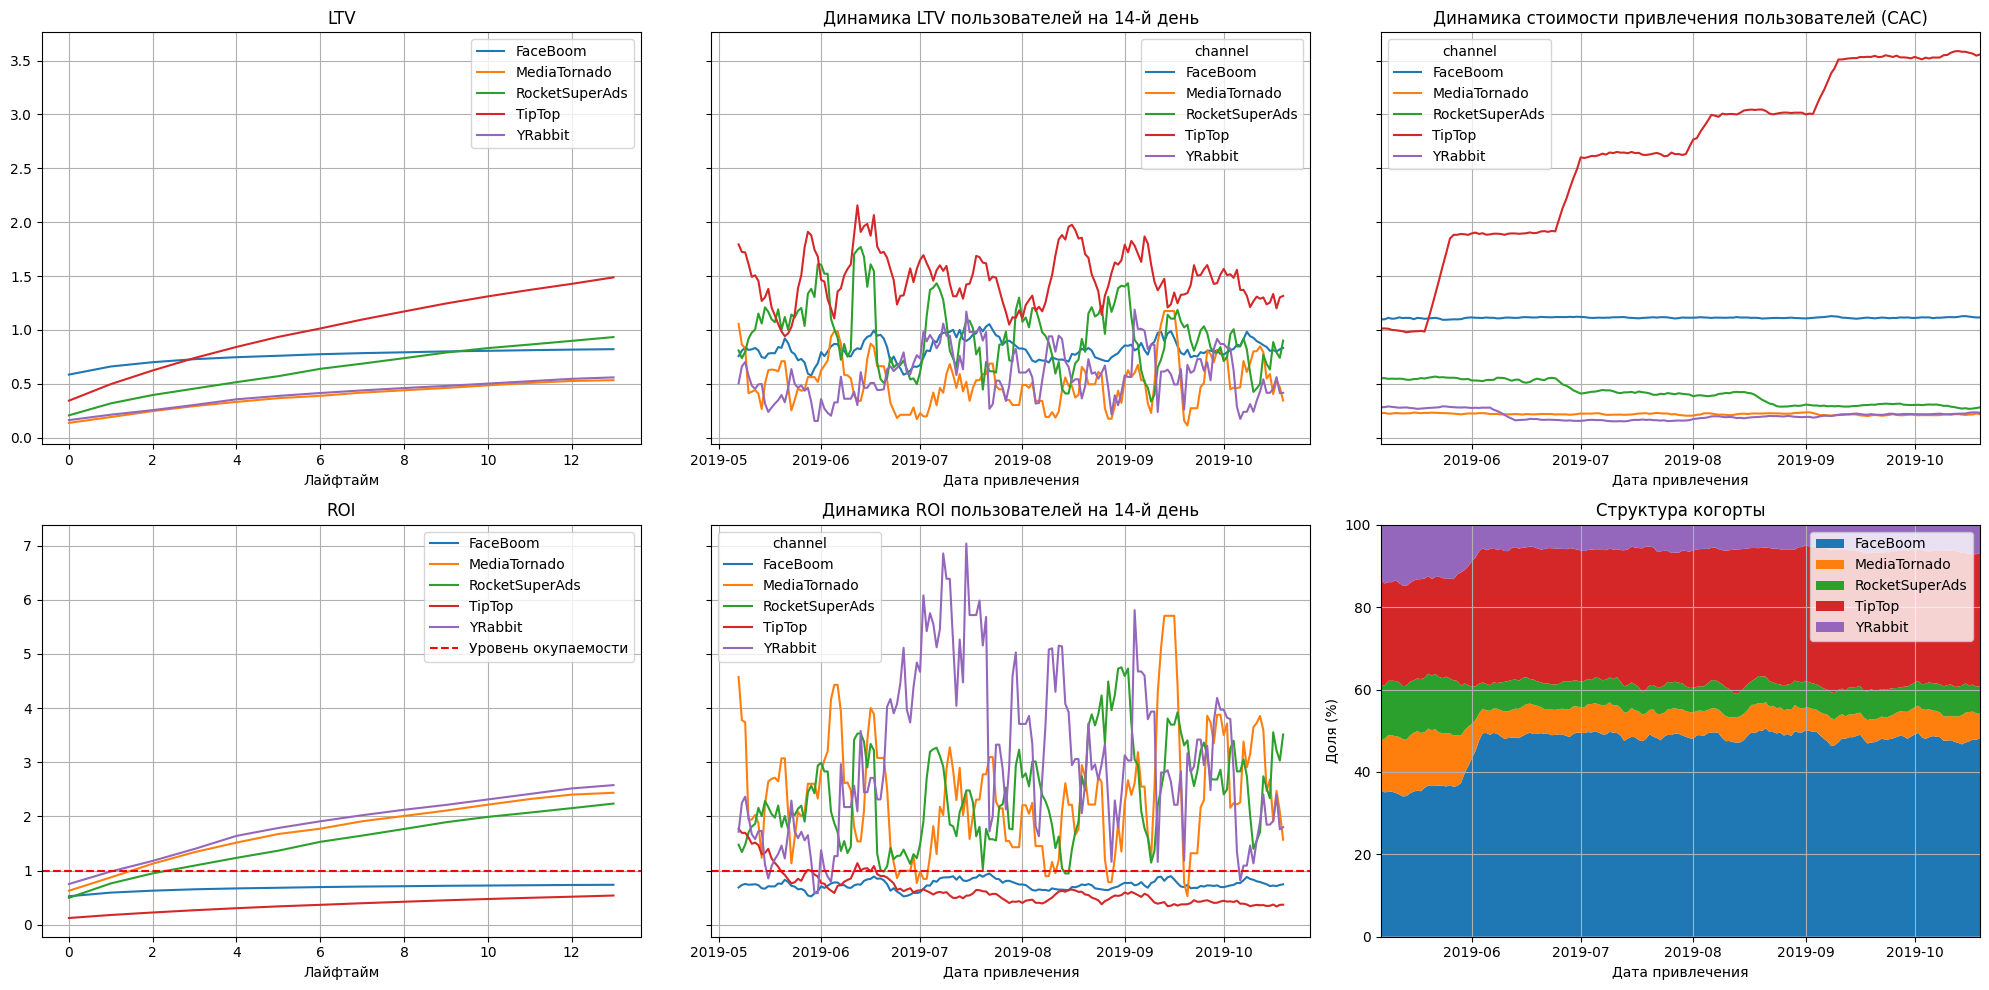

In [ ]:
# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

Наблюдения:
- в среднем, **два рекламных канала ниже уровня окупаемости: TipTop (54%) и FaceBoom (74%)**; остальные каналы рекламы на хорошем уровне 224%-258%
- ROI FaceBoom был стабильно ниже 100% в течение рассматриваемого периода, ROI TipTop резко снизился в мае, как раз когда ROI всего компонента США упал ниже 100%. В дальнейшем окупаемость этого канала продолжала простепенно снижаться.
У остальных каналов несмотря на высокие колебания ROI лишь небольшая часть привлеченных когорт не окупалась.
- каналы рекламы FaceBoom и TipTop уже на начало мая имели наибольшие доли порядка 35% и 25% по количеству привлекаемых пользователей, а **с июня доли FaceBoom и TipTop были дополнительно увеличены на 10% и более**, что усилило влияние их убыточности на ROI всего компонента США (средние доли за последние 30 дней 48% и 33% соответственно)
- стабильная убыточность канала FaceBoom обусловлена низким LTV в районе USD 0,8 без тенденции к росту и постоянной более высокой стоимостью CAC в районе USD 1,1
- убыточность канала TipTop увеличивалась с течением времени из-за постоянной растущей стоимости CAC, которая уже в середине июня превысила его средний LTV = USD 1,5
- присутствует возможность повышения общего ROI за счет сокращения до нуля долей TipTop и FaceBoom и увеличения долей остальных рекламных каналов
- **эффект на ROI United States** от увеличения до 1/3 доли каждого канала YRabbit, MediaTornado и RocketSuperAds =
</br>1/3 * (ROI YRabbit + ROI MediaTornado + ROI RocketSuperAds) - общий ROI стран United States за последние 30 дней = 1/3 * (283% + 276% + 257%) - 57% = **+ 215%**
[//]:#
Теперь мы знаем, какие рекламные каналы привели к убыточности рекламы в United States.

### Разбивка пользователей United States по устройству

In [ ]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_us, orders, observation_date, horizon_days, dimensions=['device']
)

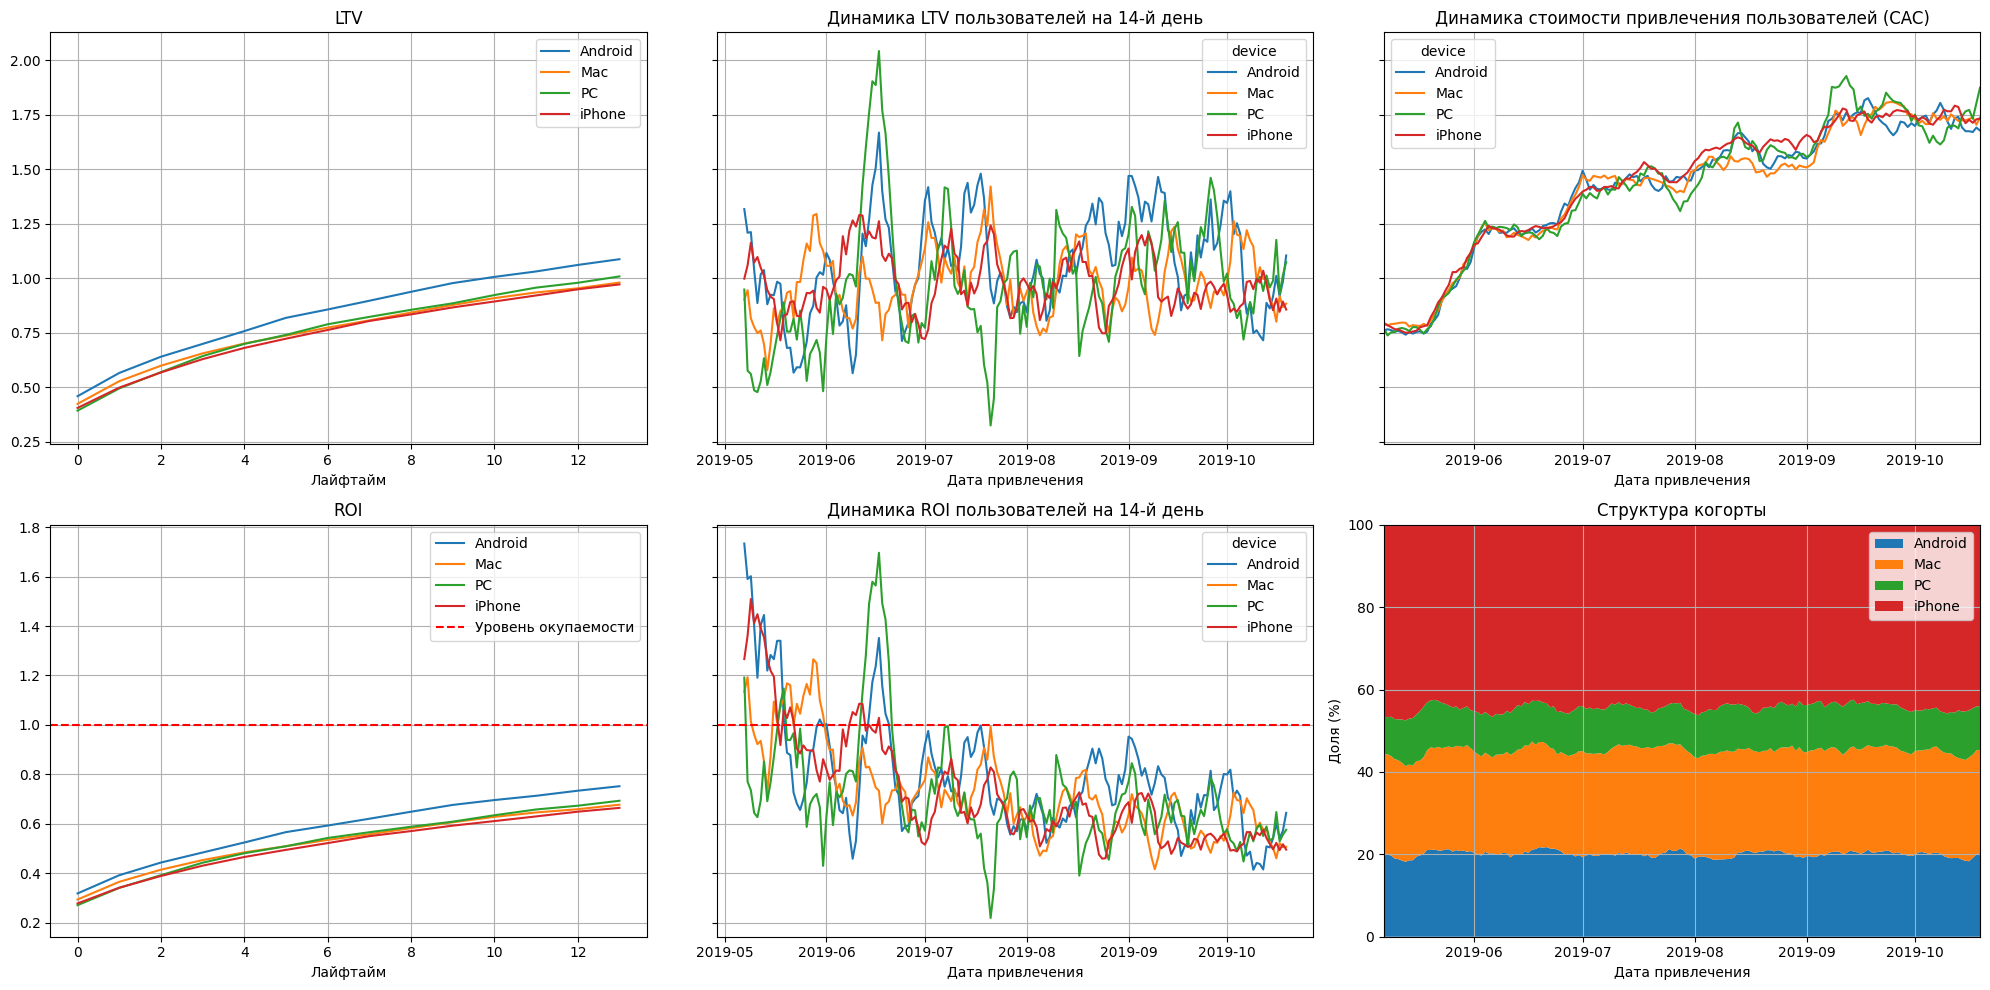

In [ ]:
# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

Наблюдение:
- такая разбивка не выделяет факторы отрицательного ROI страны United States
- увеличение доли платформы Android может повысить ROI Unites States

### Обобщенные метрики пользователей вне United States

Исследуем возможности наращивания ROI в странах, отличных от United States

In [ ]:
# делаем срез пользателей вне United States
users_non_us = users_nonorg.query('region != "United States"')

In [ ]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_non_us, orders, observation_date, horizon_days, dimensions=[]
)

In [ ]:
# выведем таблицу ROI
display(roi)

cohort_size       cac       0.0       1.0      2.0       3.0  \
cohort                                                                    
All users        30082  0.459635  0.435451  0.592768  0.73137  0.836622   

                4.0       5.0       6.0      7.0       8.0       9.0  \
cohort                                                                 
All users  0.940288  1.027414  1.114125  1.18082  1.260099  1.321453   

               10.0      11.0      12.0      13.0  
cohort                                             
All users  1.384972  1.435427  1.494264  1.541978

In [ ]:
# средний ROI за последние 30 дней
roi_dim_shares_30d = roi_history.iloc[roi_history.shape[0]-30 :]
display(roi_dim_shares_30d.mean(axis=0).sort_values(ascending=False))

cohort_size    217.933333
13.0             1.632637
12.0             1.566593
11.0             1.497977
10.0             1.448773
9.0              1.370057
8.0              1.302439
7.0              1.215377
6.0              1.138994
5.0              1.059134
4.0              0.960099
3.0              0.853411
2.0              0.740481
1.0              0.593838
cac              0.442332
0.0              0.417536
dtype: float64

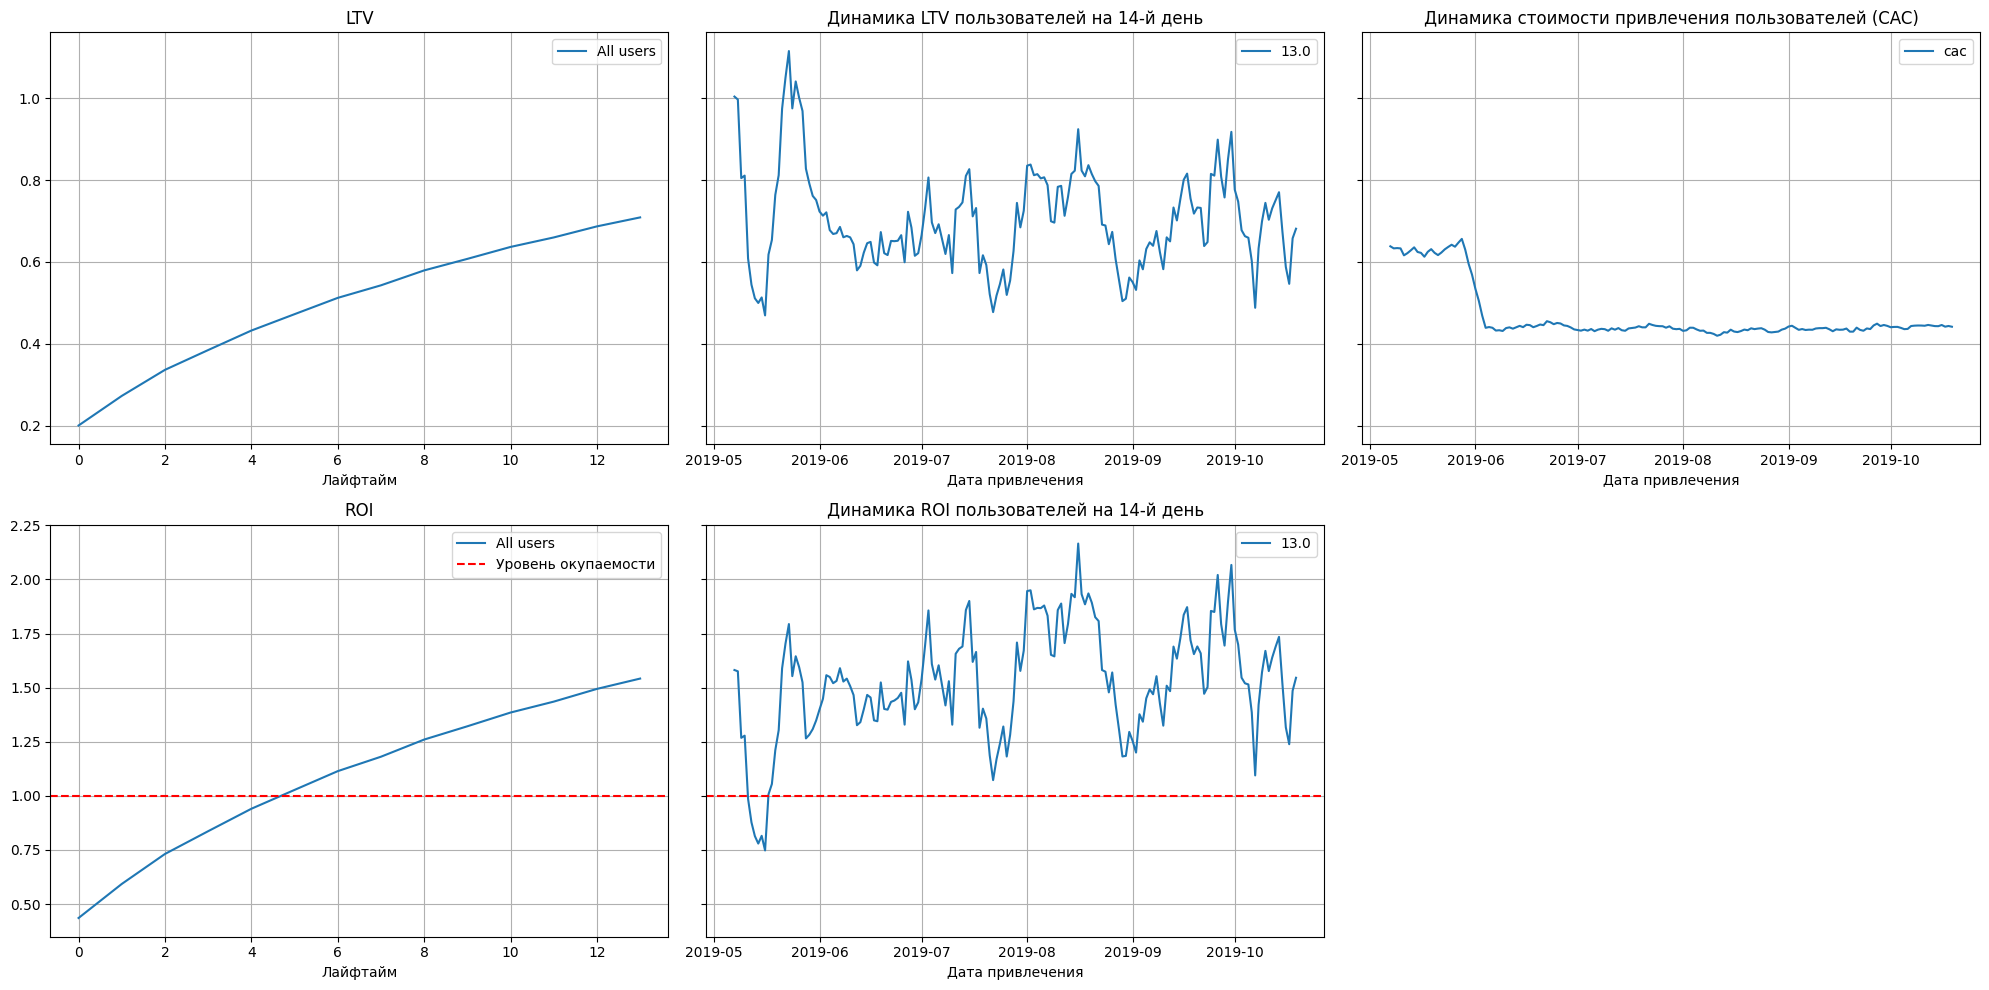

In [ ]:
# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

Наблюдение:
- ROI в среднем 154%
- этот показатель находится стабильно в положительной зоне после середины мая, без тенденции к росту
- провал в мае вызван локальным мининмумом LTV, затем скомпенсирован отскоком LTV и переходом CAC на более низкий уровень с июня

### Разбивка пользователей вне United States по каналу рекламы

In [ ]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_non_us, orders, observation_date, horizon_days, dimensions=['channel']
)

In [ ]:
# выведем таблицу ROI
display(roi)

cohort_size       cac       0.0       1.0       2.0  \
channel                                                                   
AdNonSense                 3702  1.008023  0.501010  0.584460  0.639288   
LeapBob                    8103  0.210000  0.509752  0.741436  0.978967   
OppleCreativeMedia         8139  0.249908  0.389100  0.526504  0.686996   
WahooNetBanner             8082  0.601856  0.317853  0.484298  0.629588   
lambdaMediaAds             2056  0.727237  0.632899  0.887333  1.070887   

                         3.0       4.0       5.0       6.0       7.0  \
channel                                                                
AdNonSense          0.678069  0.701069  0.726752  0.748147  0.761519   
LeapBob             1.120908  1.236450  1.374282  1.498034  1.589535   
OppleCreativeMedia  0.826849  0.964769  1.065354  1.161037  1.238564   
WahooNetBanner      0.737309  0.858780  0.946188  1.049868  1.126808   
lambdaMediaAds      1.245178  1.432136  1.595673  1.735841  1.859323   

                         8.0       9.0      10.0      11.0      12.0      13.0  
channel                                                                         
AdNonSense          0.782922  0.796294  0.800573  0.808597  0.820631  0.831337  
LeapBob             1.759730  1.877030  1.988470  2.085248  2.179087  2.252399  
OppleCreativeMedia  1.314661  1.388265  1.457448  1.507006  1.580649  1.637075  
WahooNetBanner      1.205193  1.271878  1.350049  1.411192  1.477881  1.526304  
lambdaMediaAds      1.986818  2.070251  2.171709  2.241794  2.331922  2.428712

In [ ]:
# выведем структуру ROI по количеству новых пользователей за последние 30 дней
dim = roi_history.index.names[:len(roi_history.index.names)-1]
roi_dim_shares = roi_history.reset_index().pivot_table(index='dt', columns=dim, values='cohort_size', aggfunc='sum')
roi_dim_shares['total'] = roi_dim_shares.sum(axis=1)
roi_dim_shares = roi_dim_shares.div(roi_dim_shares['total'], axis=0).drop(columns='total')
#display(roi_dim_shares)
roi_dim_shares_30d = roi_dim_shares.iloc[roi_dim_shares.shape[0]-30 :]
display(roi_dim_shares_30d.mean(axis=0).sort_values(ascending=False))

channel
OppleCreativeMedia    0.284568
WahooNetBanner        0.283304
LeapBob               0.274188
AdNonSense            0.100664
lambdaMediaAds        0.057276
dtype: float64

In [ ]:
# ROI за последние 30 дней
# выведем структуру ROI по количеству новых пользователей за последние 30 дней
dim = roi_history.index.names[:len(roi_history.index.names)-1]
roi_dim_shares = roi_history.reset_index().pivot_table(index='dt', columns=dim, values=13, aggfunc='sum')
#display(roi_dim_shares)
roi_dim_shares_30d = roi_dim_shares.iloc[roi_dim_shares.shape[0]-30 :]
display(roi_dim_shares_30d.mean(axis=0).sort_values(ascending=False))

channel
lambdaMediaAds        2.786801
LeapBob               2.413782
OppleCreativeMedia    1.851607
WahooNetBanner        1.388738
AdNonSense            0.978015
dtype: float64

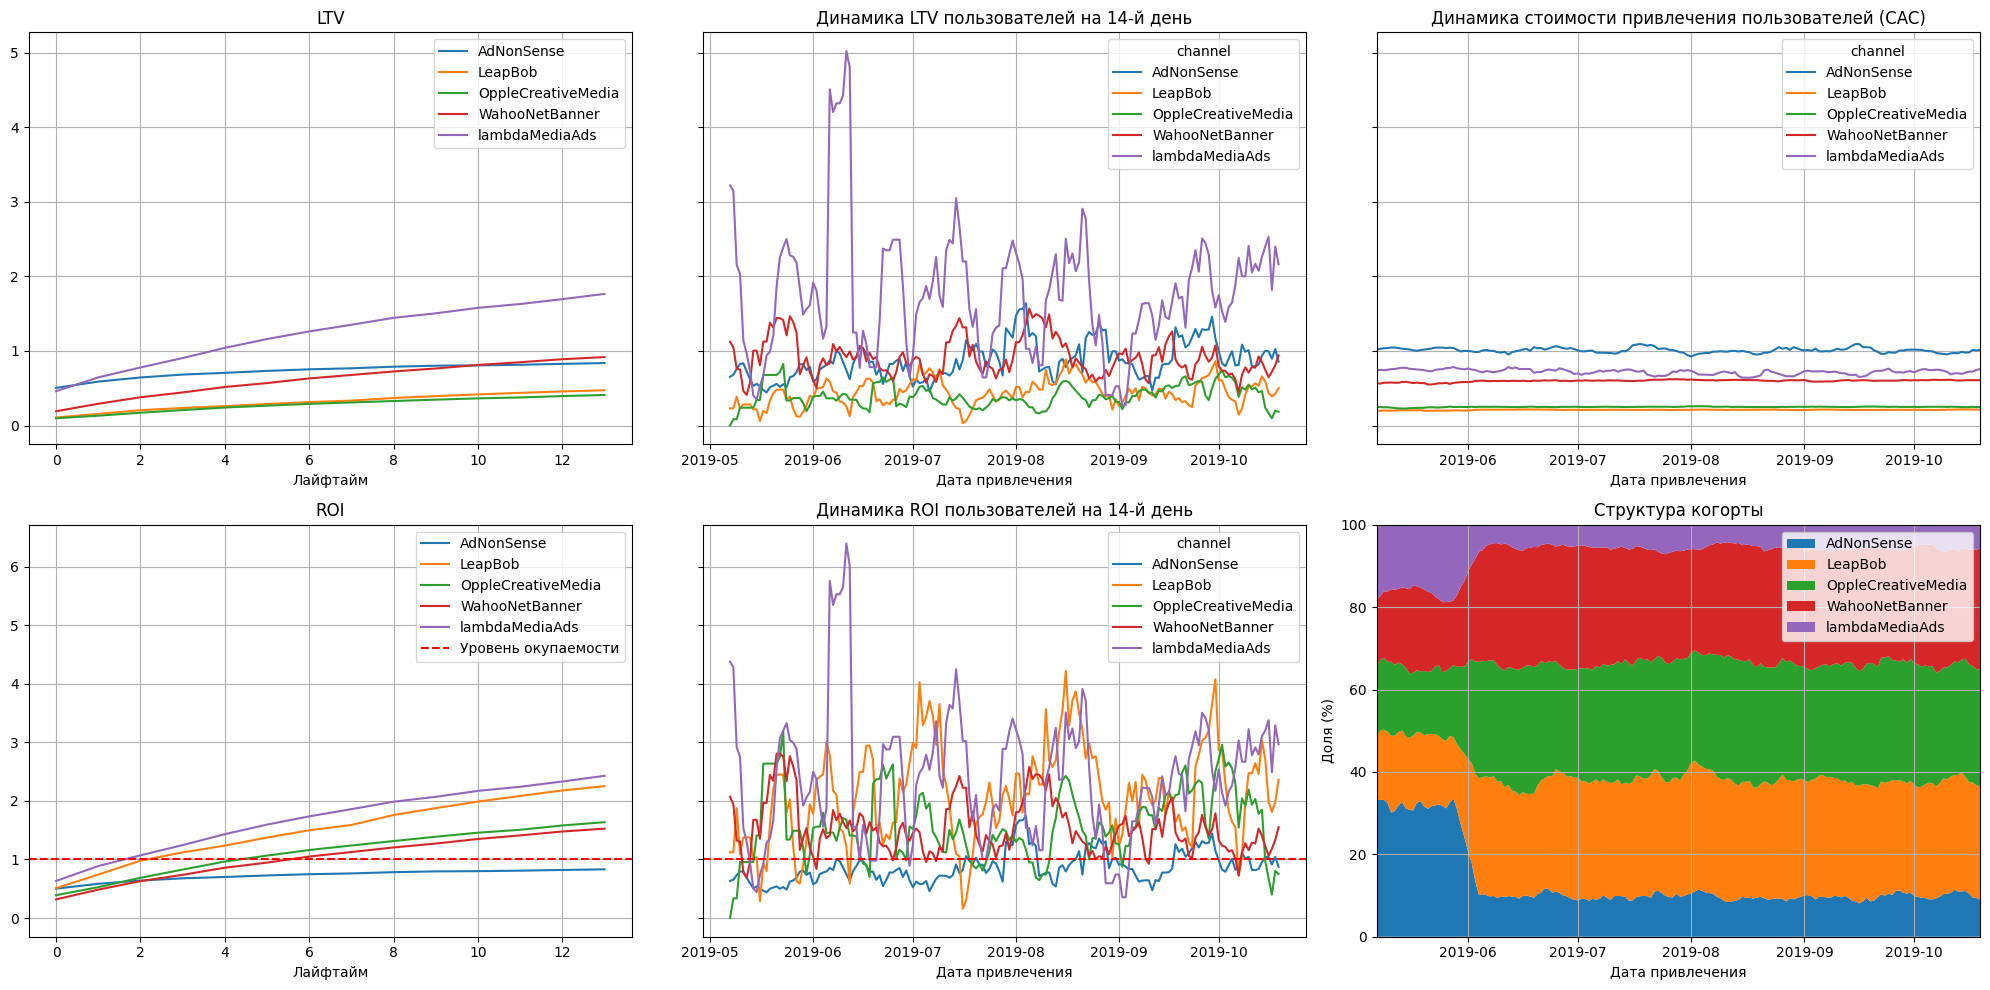

In [ ]:
# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

Налюдения:
- наиболее эффективные каналы рекламы lambdaMediaAds и LeapBob, хотя и наиболее волатильные по ROI
- в начале июня была изменена структура каналов рекламы, с сокращением доли каналов AdNonSence и lambdaMediaAds, у которых наибольшая стоимость привлечения клиентов
- присутствует возможность повышения общего ROI за счет сокращения до нуля доли AdNonSence и увеличения долей рекламных каналов lambdaMediaAds и LeapBob
- **эффект на ROI стран вне United States** от увеличения до 50% доли каждого канала lambdaMediaAds и LeapBob =
</br>50% * (ROI lambdaMediaAds + ROI LeapBob) - общий ROI стран вне United States за последние 30 дней = 50% * (279% + 241%) - 163% = **+ 97%**

### Разбивка пользователей вне United States по устройству

In [ ]:
# считаем LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    users_non_us, orders, observation_date, horizon_days, dimensions=['device']
)

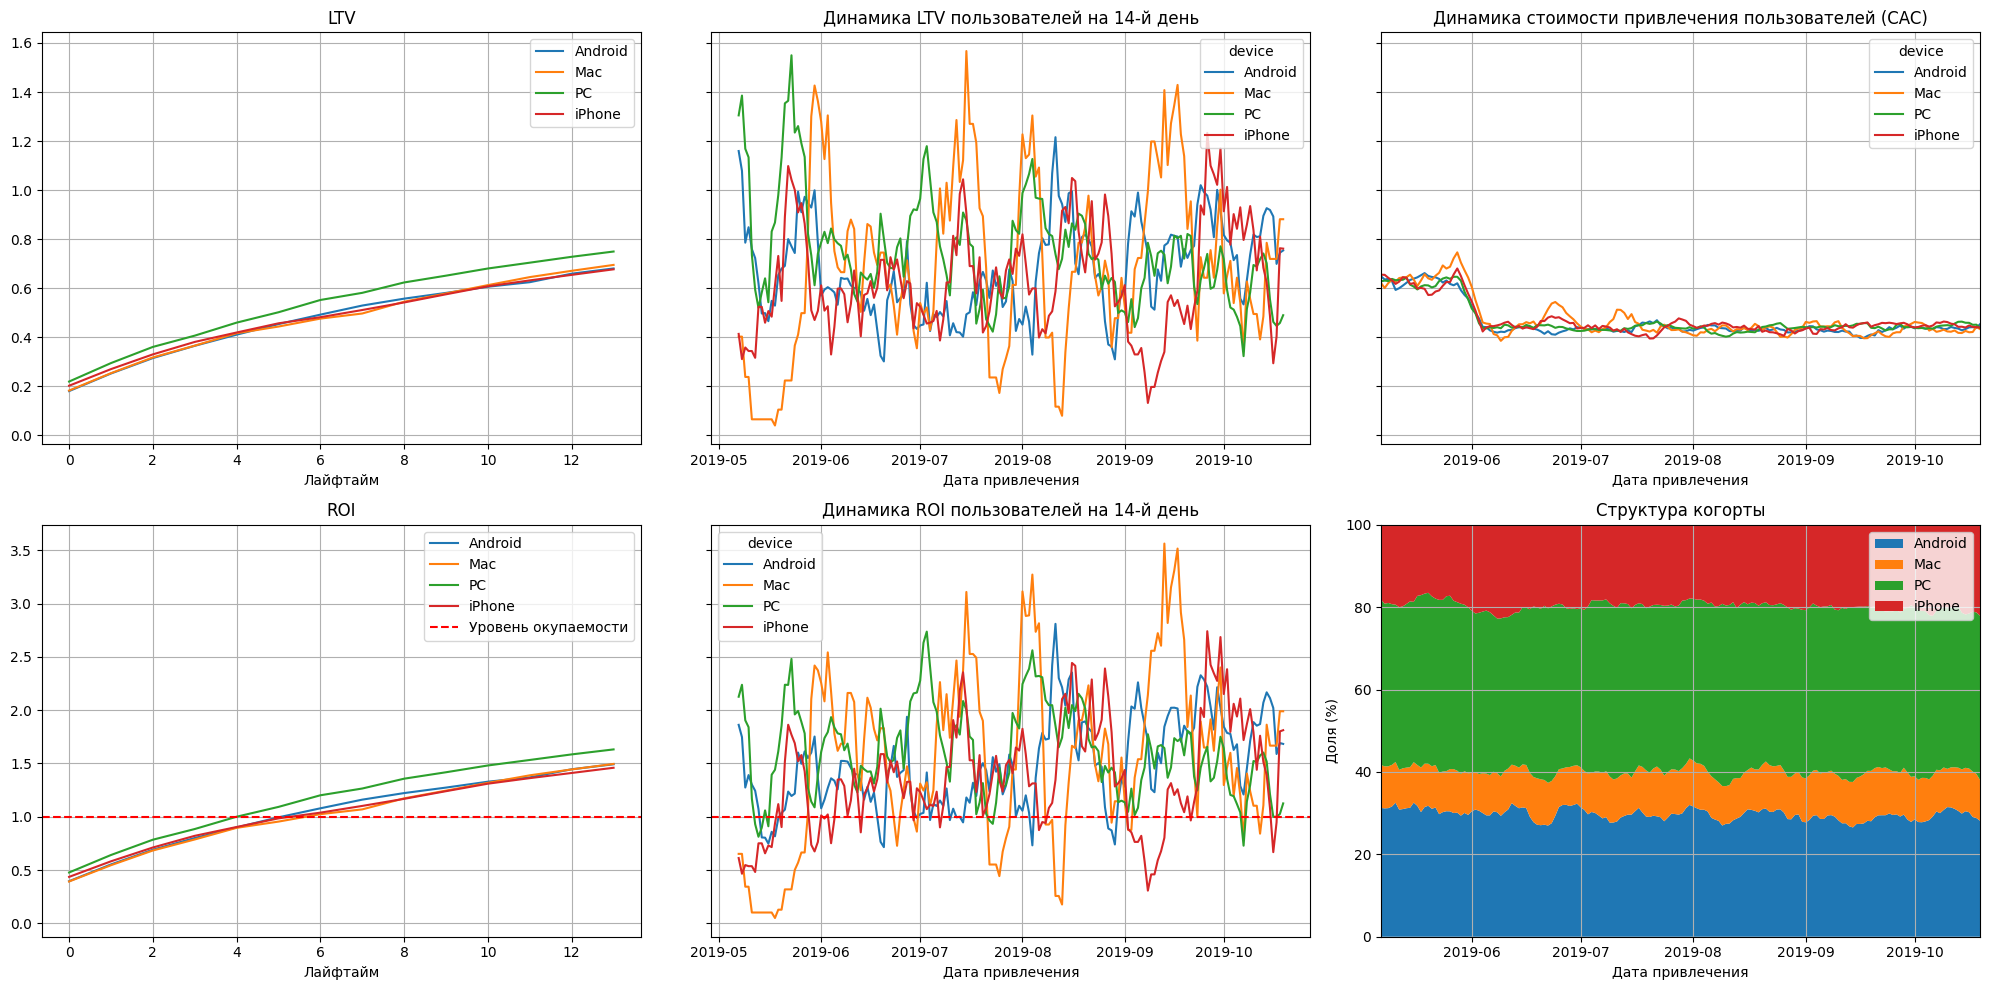

In [ ]:
# постройте графики LTV, CAC и ROI
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

Наблюдение:

- такая разбивка не выделяет факторы для значительного наращивания ROI в странах, отличных от United States
- увеличение доли PC может повысить ROI вне United States

## Проанализируем факторы, влияющие на доходы от "неорганического" пользователя (LTV)  
1) конверсию пользователей (CR)  
2) удержание пользователей (retention)

Выясним, есть ли возможности для повышения LTV

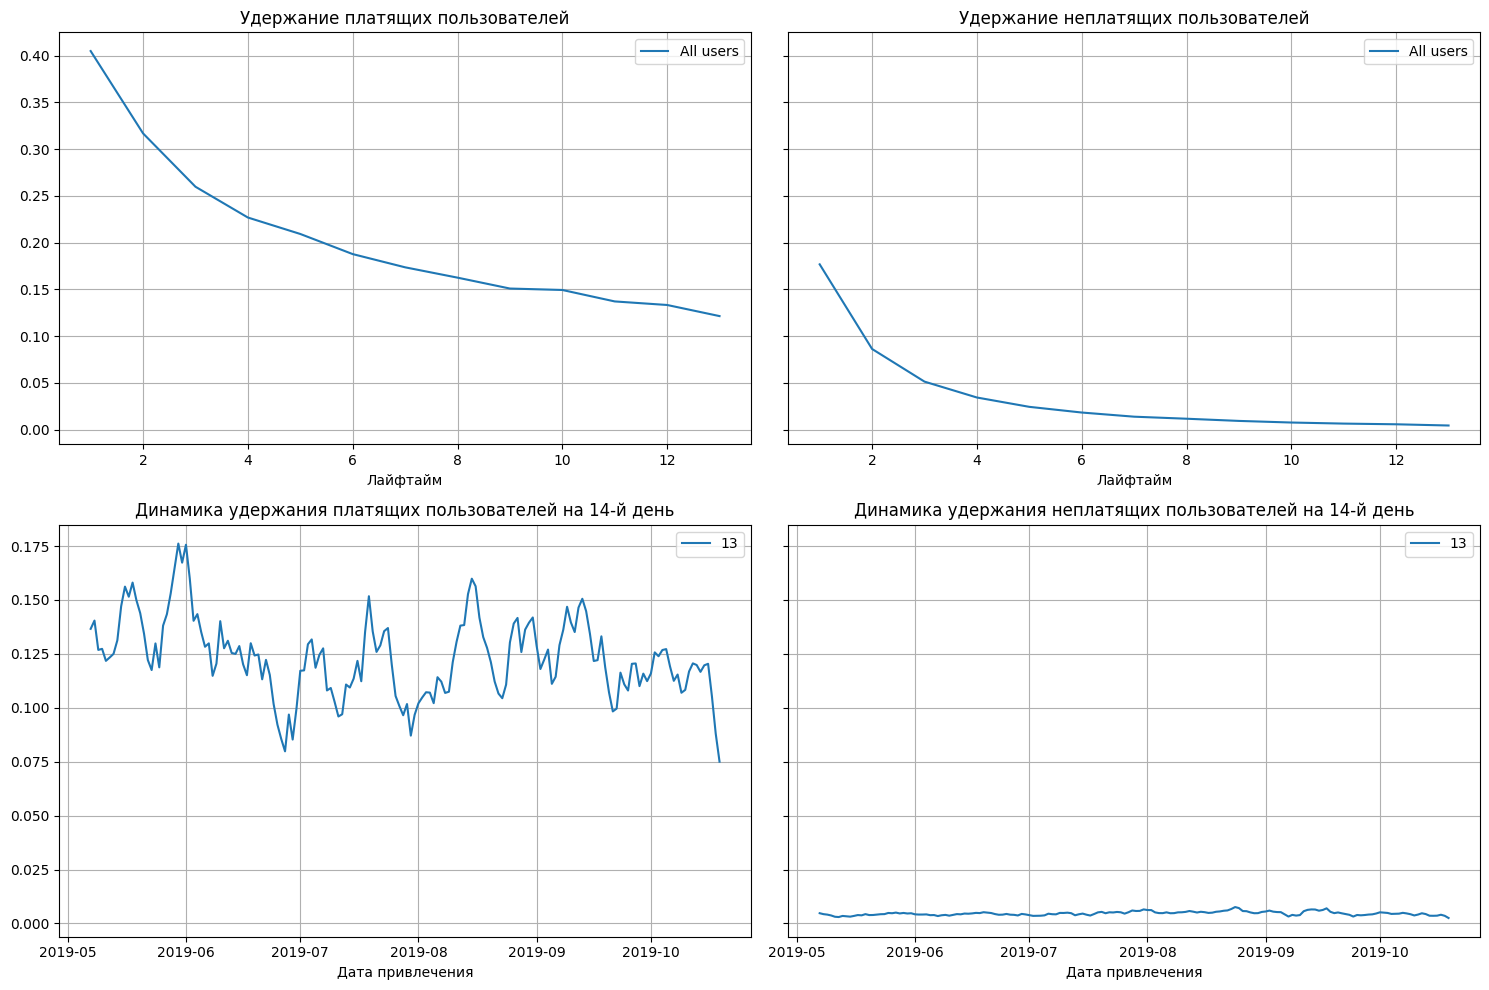

In [ ]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, horizon_days, dimensions=[]
)

plot_retention(retention_grouped, retention_history, horizon_days)

Наблюдения:  
- на обобщенном графике не видно выраженных проблем
- обращает внимание только снижение удержания платящих пользователей в конце октября до минимального значения



### Удержание пользователей по региону

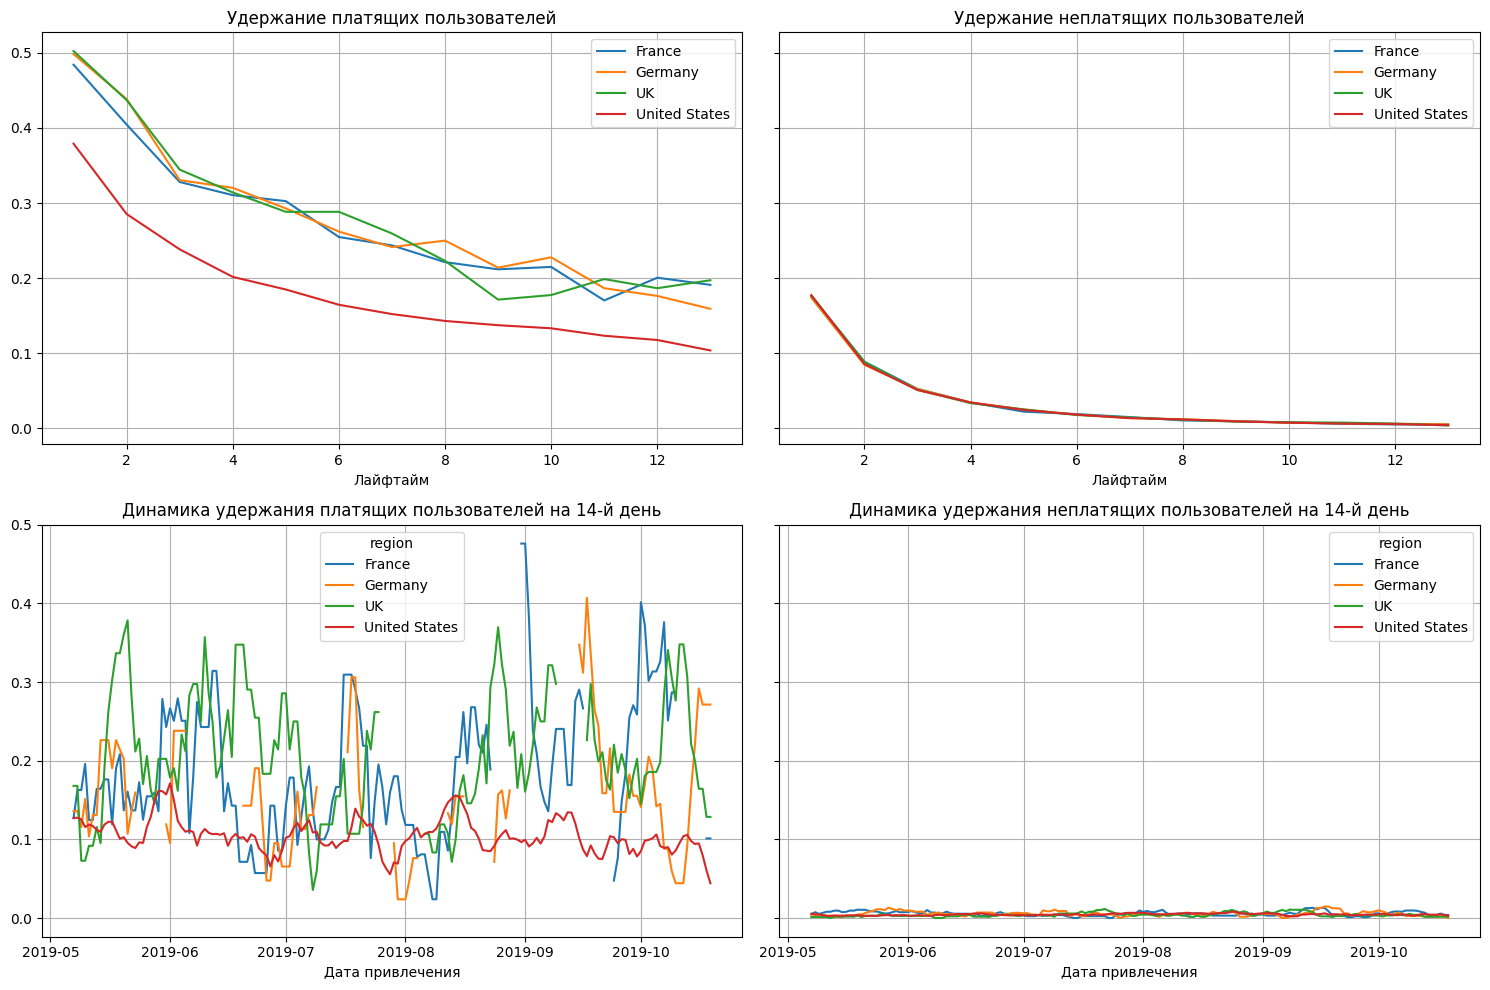

In [ ]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    users, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

In [ ]:
ret = retention_history.reset_index()
# display(ret.loc[(ret['region']!='United States') & (ret[13]==0) & (ret['payer']==False)])
display('Средний размер неплатящих когорт вне United States с нулевым удержанием на 14-й день:', ret.loc[(ret['region']!='United States') & (ret[13]==0) & (ret['payer']==False), ['cohort_size']].mean())
display('Средний размер неплатящих когорт вне United States с ненулевым удержанием на 14-й день:', ret.loc[(ret['region']!='United States') & (ret[13]!=0) & (ret['payer']==False), ['cohort_size']].mean())

display('Средний размер платящих когорт вне United States с нулевым удержанием на 14-й день:', ret.loc[(ret['region']!='United States') & (ret[13]==0) & (ret['payer']==True), ['cohort_size']].mean())
display('Средний размер платящих когорт вне United States с ненулевым удержанием на 14-й день:', ret.loc[(ret['region']!='United States') & (ret[13]!=0) & (ret['payer']==True), ['cohort_size']].mean())

'Средний размер неплатящих когорт вне United States с нулевым удержанием на 14-й день:'

cohort_size    86.99403
dtype: float64

'Средний размер неплатящих когорт вне United States с ненулевым удержанием на 14-й день:'

cohort_size    91.513812
dtype: float64

'Средний размер платящих когорт вне United States с нулевым удержанием на 14-й день:'

cohort_size    3.051587
dtype: float64

'Средний размер платящих когорт вне United States с ненулевым удержанием на 14-й день:'

cohort_size    4.443548
dtype: float64

Наблюдения:
- удержание платящих пользователей значительно лучше, чем не платящих (практически не удерживаются), что является нормальным
- удержание пользователей United States самое низкое в среднем, и наименее волатильное
- на графике динамики удержания платящих пользователей на 14-й день присутствуют разрывы у всех стран, кроме United States; это не явлется проблемой, т.к. в LTV разывов нет. Возможное объяснение - меньшие размеры когорт в целом по сравнению с United States, и в особенности - в определенные даты, т.к. средние размеры когорт отличаются почти в полтора раза.

### Удержание пользователей United States по каналу рекламы

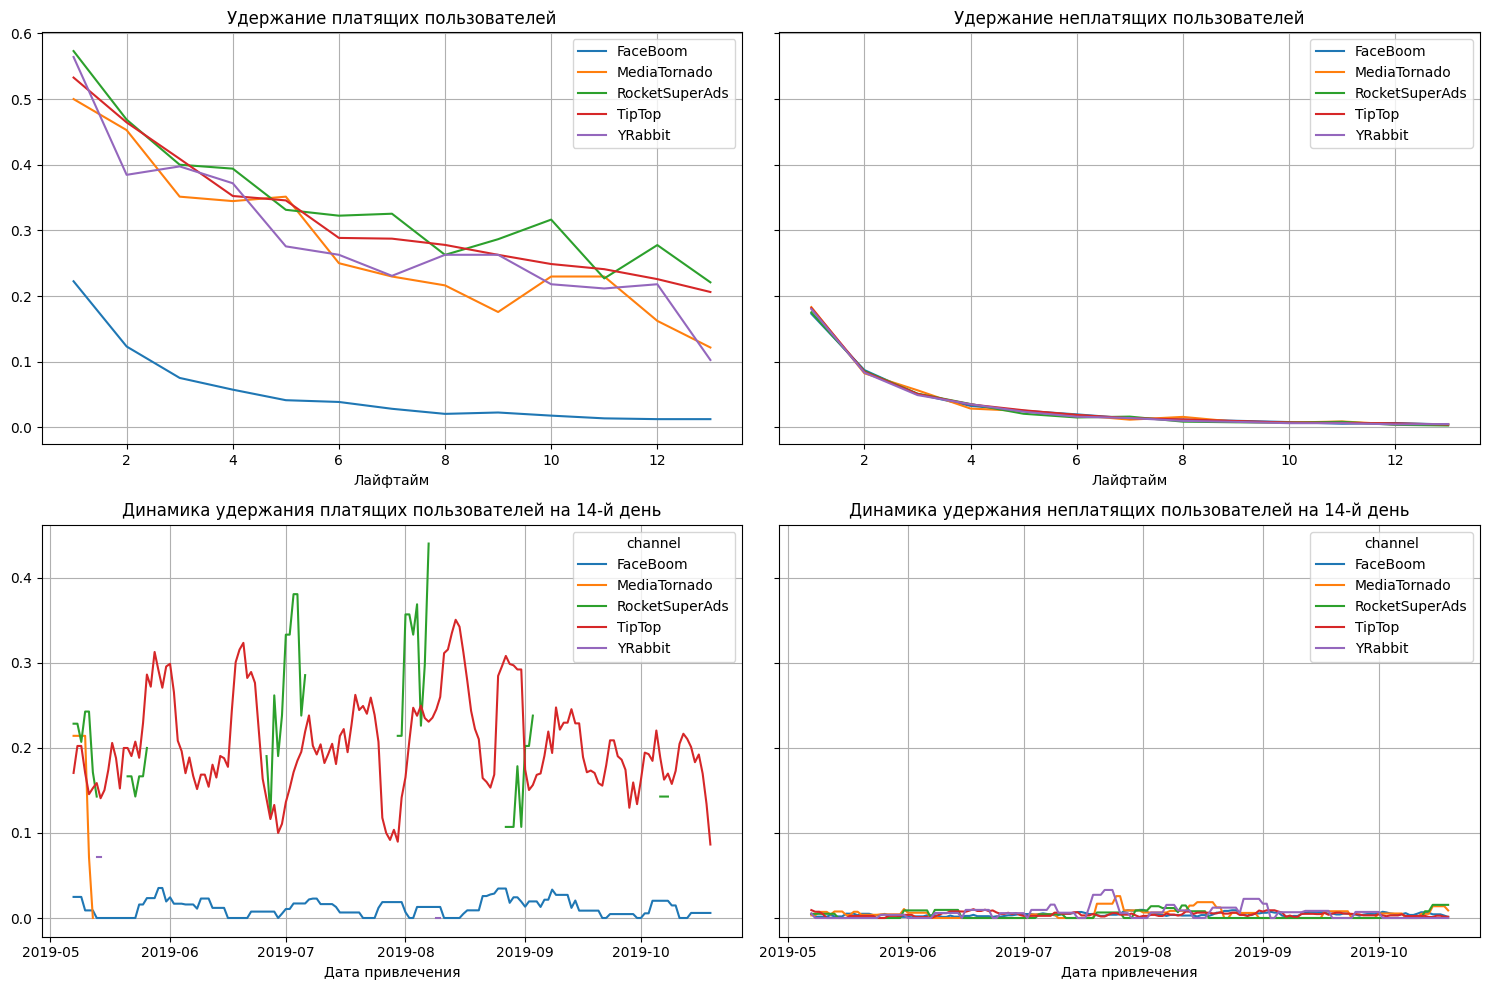

In [ ]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    users_us, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

In [ ]:
ret = retention_history.reset_index()
# display(ret.loc[(ret['region']!='United States') & (ret[13]==0) & (ret['payer']==False)])
display('Средний размер неплатящих когорт вне United States с нулевым удержанием на 14-й день:', ret.loc[(ret['channel']!='TipTop') & (ret['channel']!='FaceBoom') & (ret[13]==0) & (ret['payer']==False), ['cohort_size']].mean())
display('Средний размер неплатящих когорт вне United States с ненулевым удержанием на 14-й день:', ret.loc[(ret['channel']!='TipTop') & (ret['channel']!='FaceBoom') & (ret[13]!=0) & (ret['payer']==False), ['cohort_size']].mean())

display('Средний размер платящих когорт вне TipTop, FaceBoom с нулевым удержанием на 14-й день:', ret.loc[(ret['channel']!='TipTop') & (ret['channel']!='FaceBoom') & (ret[13]==0) & (ret['payer']==True), ['cohort_size']].mean())
display('Средний размер платящих когорт вне TipTop, FaceBoom с ненулевым удержанием на 14-й день:', ret.loc[(ret['channel']!='TipTop') & (ret['channel']!='FaceBoom') & (ret[13]!=0) & (ret['payer']==True), ['cohort_size']].mean())

'Средний размер неплатящих когорт вне United States с нулевым удержанием на 14-й день:'

cohort_size    23.004274
dtype: float64

'Средний размер неплатящих когорт вне United States с ненулевым удержанием на 14-й день:'

cohort_size    23.229167
dtype: float64

'Средний размер платящих когорт вне TipTop, FaceBoom с нулевым удержанием на 14-й день:'

cohort_size    1.608365
dtype: float64

'Средний размер платящих когорт вне TipTop, FaceBoom с ненулевым удержанием на 14-й день:'

cohort_size    2.373626
dtype: float64

Наблюдения:  
- самым низким удержанием обладает канал FaceBoom, что вероятно и является причиной недостаточного для достижения рентабельности LTV. После отказа от этого канала удержание United States приблизится к удержанию других стран.
- динамика удержания на 14 день прервывается или отсутствует у каналов MediaTornado, RockedSuperAds и YRabbit, ситуация такая же как в разбивке по странам. Разрывы вероятно сократятся после увеличения доли соответствующих рекламных каналов.

### Удержание пользователей United States по устройству

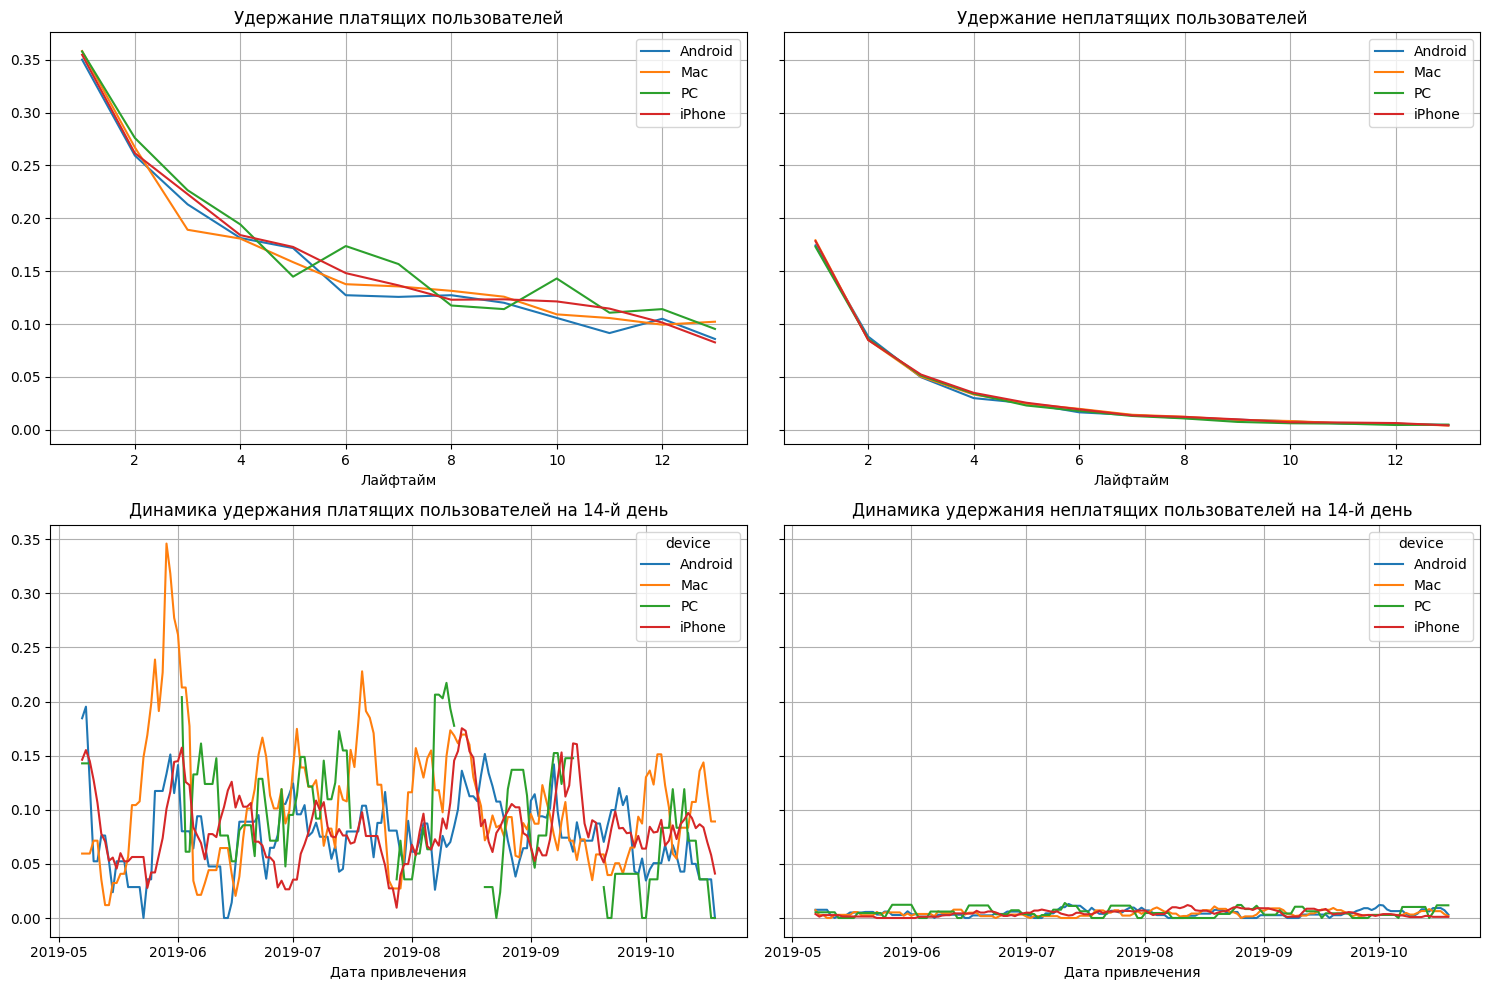

In [ ]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    users_us, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Наблюдение:
- единственная особенность - разрыв графика динамики удержания платящих пользователей на PC.

### Обобщенная конверсия пользоватей

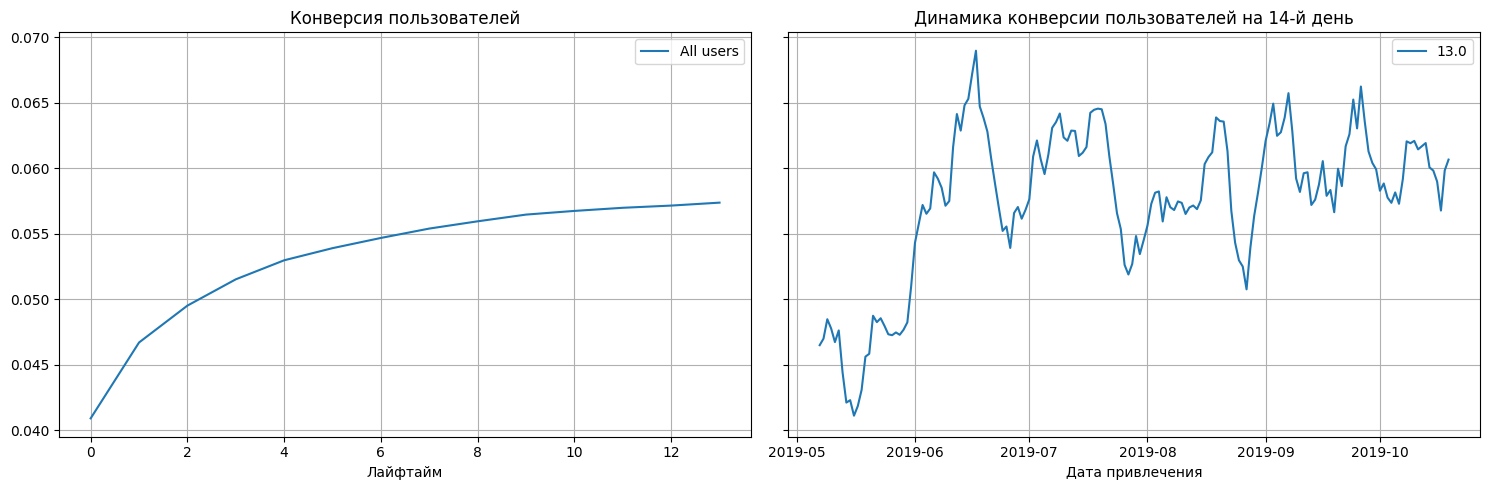

In [ ]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=[]
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наблюдение:
- обобщенная конверсия пользователей на 14-й день перешла в более высокий диапазон в начале июня

### Конверсия пользователей по региону

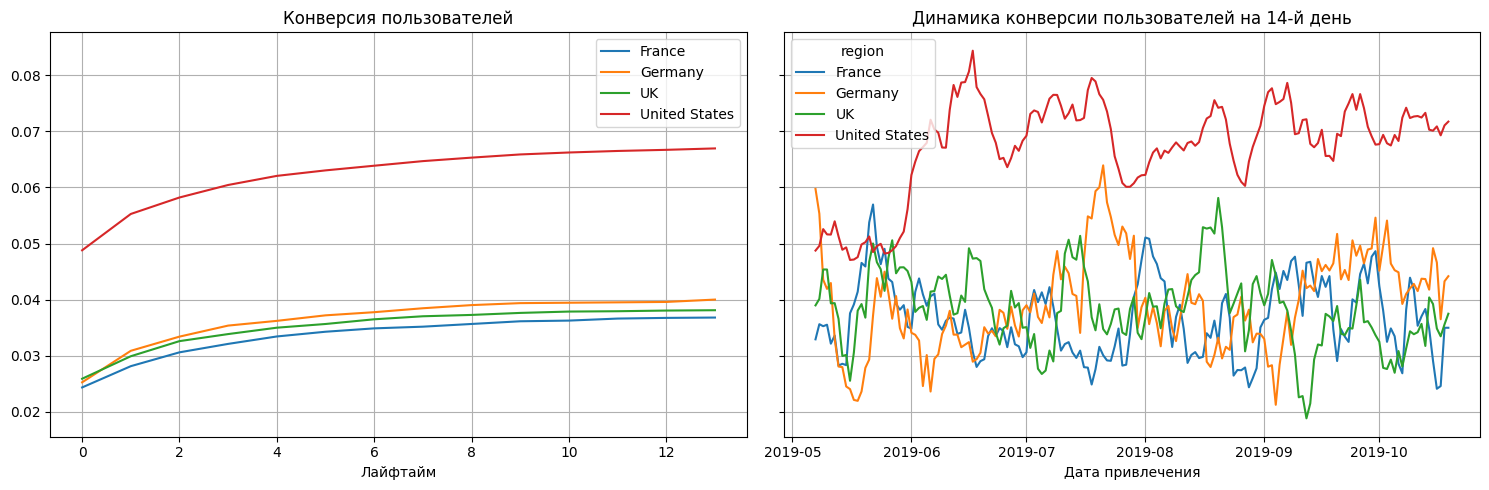

In [ ]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наблюдения:
- United States значительно превосходит остальные страны по конверсии за счет конверсии первого дня
- рост обобщенной конверсии в начале июня связан с динамикой конверсии United States
</br>
</br>Далее рассмотрим конверсию на крупнейшем рынке - United States.

### Конверсия United States по каналу рекламы

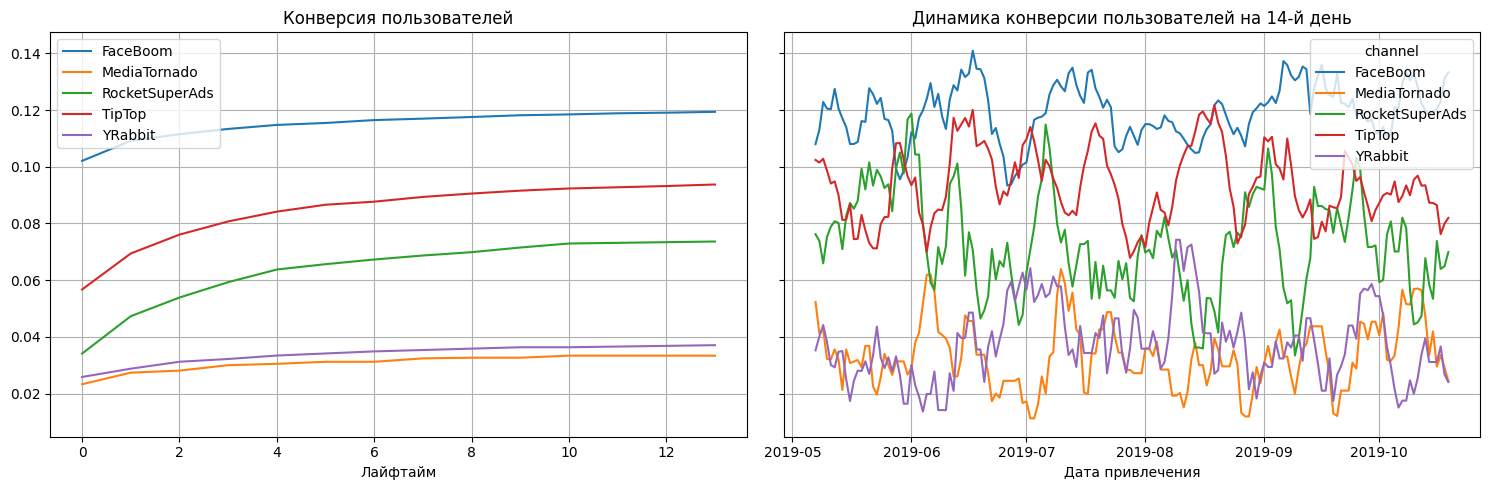

In [ ]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users_us, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наблюдения:
- наибольшая конверсия у каналов FaceBoom и TipTop, от которых мы решили отказаться по причине неокупаемости. Конверсия FaceBoom отличается от TipTop и RocketSuperAds низкими значениями на всех лайфатаймах после 1 дня, что, по-видимому, является следствием плохого удержания как обнаружили ранее. Посколе отказа от FaceBoom и TipTop конверсия United States приблизится к уровню других стран.
- наименьшая конверсия среди каналов рекламы на рынке United States- у YRabbit и MediaTornado, относящихся к хорошо окупаемым. Повышение их конверсии положительно скажется на общей окупаемости рекламы.

### Конверсия United States по устройству

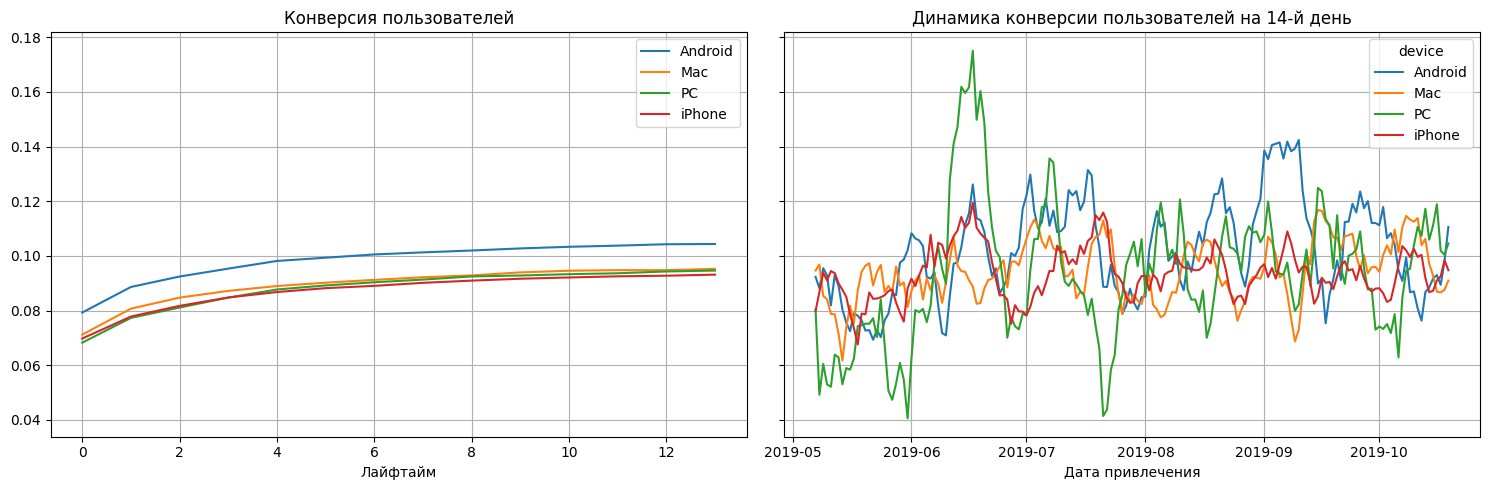

In [ ]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    users_us, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Наблюдение:
- по конверсии Android значительно превосходит другие стройства, это транслируется в соотношение LTV

# Выводы
- на этапе предобработки исправили типы данных c object на datetime64, перевели названия столбцов в snake_case? пропуски и дубликаты не обнаружены.
- на этапе создания функций для расчета и визуализации метрик к стандартным функциям добавили:
 - график структуры ROI, LTV и CAC, выраженной в долях от общего количества новых пользователей
 - функцию для вывода структуры пользователей в таблице для раздела "Анализ структуры пользователей"
- на этапе расчета окупаемости и декомпозиции проблемы:
 - на основе обобщенных графиков ROI, LTV и CAC обнаружили проблему: средний ROI за рассматриваемый период около 80%, ROI на 14 день снижался в течение всего рассматриваемого периода, по результатам июня опустися в зону убыточности
 - на основе разбивки по региону определили, что динамика ROI United States была определяющим негативным фактором для общего ROI с учетом более 60% доли пользователей United States среди всех "неорганических" пользователей
 - по ROI United States - единственная страна, где после июня показатель  стабильно находился ниже 100%. Средние ROI остальных стран на уровне 150-160%
 - пользователи United States приносили значительно более высокий доход, за счет покупки в первый день лайфтайма (USD 0,4 против примерно USD 0,2)
 - расходы на привлечение пользователя в конце мая резко понизились во всех странах, кроме United States, где они наоборот подскочили и продолжили рост
 - разбивка United States по каналу рекламы показала, что два рекламных канала ниже уровня окупаемости: TipTop (54%) и FaceBoom (74%); остальные каналы рекламы на хорошем уровне 224%-258%
 - при этом FaceBoom и TipTop уже на начало мая имели наибольшие доли порядка 35% и 25% по количеству привлекаемых пользователей, а с июня доли FaceBoom и TipTop были дополнительно увеличены на 10% и более, что усилило влияние их убыточности на ROI всего компонента США (средние доли за последние 30 дней 48% и 33% соответственно)
 - стабильная убыточность канала FaceBoom обусловлена низким LTV в районе USD 0,8 и более высокой стоимостью CAC в районе USD 1,1
 - убыточность канала TipTop увеличивалась с течением времени из-за постоянной растущей стоимости CAC, которая уже в середине июня превысила его средний LTV = USD 1,5
 - присутствует возможность повышения ROI United States на 215% за счет сокращения до нуля долей TipTop и FaceBoom и увеличения долей остальных рекламных каналов
 - обобщенные метрики пользователей вне United States также могут быть повышены на 97% за счет оптимизации структуры рекламных каналов: сокращения до нуля доли AdNonSence и увеличения долей рекламных каналов lambdaMediaAds и LeapBob
 - **общий эффект на ROI от предлагаемой оптимизации структуры рекламных каналов + 175%** = доля United States 66% * эффект от оптимизации ROI 215% + доля стран вне United States 34% * эффект от оптимизации ROI 97%  
 - некоторое **повышение ROI возможно также за счет оптимизации распределения рекламы по устройствам**: увеличение доли платформы Android в Unites States и увеличение доли PC в странах вне United States